# Experiments- A Generic State-Space Modeling Utilizing Stochastic Neural Networks and Dynamic Bayesian Layers

## 1. Introduction

### 1.1. Setup the environment

Please check the numpy version before proceeding. To check current version, after importing run  
***np.version.version***  
The version required for this file is 1.18.5. If its not the same then install the required version using the following code and then restart the kernel and continue from the next cell.  
***pip install numpy==1.18.5***

In [1]:
import numpy as np
import pandas as pd
import copy
import sys
from numpy.random import choice
import seaborn as sns
import tensorflow as tf
import sklearn
from sklearn import datasets
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.font_manager import FontProperties
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Layer, Input, advanced_activations, Embedding, LSTM, multiply, Reshape, Bidirectional, GRU, SimpleRNN
from tensorflow.python.keras import backend as K
from keras.metrics import RootMeanSquaredError
from keras.models import load_model, save_model
#from keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, hamming_loss, jaccard_score, roc_auc_score, log_loss, zero_one_loss, brier_score_loss, label_ranking_loss, mean_squared_error
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
import numpy as np
import scipy.stats
import math
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn import datasets
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels
import sklearn
import math
import statsmodels.api as sm
from sklearn import datasets, linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, ConfusionMatrixDisplay
#pd.options.mode.chained_assignment = None  # default='warn'
import scipy.stats as stats
from numpy.random import choice
from scipy.stats import multivariate_normal,norm, zscore
import plotly
import plotly.express as px
import time
# mlp for multi-output regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import RepeatedKFold
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import RootMeanSquaredError
from tensorflow.python.keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import RootMeanSquaredError
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Layer, Input, concatenate, LSTM, Multiply, Add, Subtract, Lambda
from keras.utils import np_utils

#from keras.optimizers import Adam
import collections
import tensorflow as tf
import tensorflow_probability as tfp
tfd=tfp.distributions
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('seaborn-white')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 20
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 20
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['axes.facecolor']='white'
matplotlib.rcParams['savefig.facecolor']='white'
matplotlib.rcParams['axes.spines.top']=False
matplotlib.rcParams['axes.spines.right']=False
matplotlib.rcParams['axes.grid']=False

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### 1.2. System Properties

*Revise the system properties when using a previously preprocessed dataset if needed*

\begin{equation}
\text{Discrete Latent State: }\Pr(m_k= k'|m_{k-1}=k) = p_0[k,k'], 
\end{equation}
\begin{equation}
\text{Continuous Latent State: }x_k =x_{k-1} - \exp(-b_{m_k}) + \mathcal{N}(0,Q),
\end{equation}

\begin{equation}
\text{Continuous Hazard State: }\lambda_k= 1/(1+ e^{-(\alpha x_k+\beta_0)}),
\end{equation}

\begin{equation}
\text{$s_1$ Continuous Sensors: } {y}^{cont}_{k,1:s_1}= \mathbf{H}^\top\begin{bmatrix}
1-m_k \\
m_k \\
\end{bmatrix}x_k + \mathcal{N}(0,{R}),
\end{equation}

\begin{equation}
\text{$s_2$ Binary Sensors: } \Pr(y^{bin}_{k,1:s_2}=1)=
\begin{cases}
 bin_1 & \text{if } m_k=1, \, \\
 1-bin_1 & \text{if } m_k=0
\end{cases}
\end{equation}

\begin{equation}
\text{$s_3$ Categorical Sensors: } \Pr(y^{cat}_{k,1:s_3}=\{1,2,3\})=
\begin{cases}
 c_1,c_2,c_3 & \text{if } m_k=0, x_k < 0.5, \, \\
 c_1,c_2,c_3 & \text{if } m_k=1, x_k < 0.5, \, \\
 c_1,c_2,c_3 & \text{if } m_k=0, x_k >= 0.5, \, \\
 c_1,c_2,c_3 & \text{if } m_k=1, x_k >= 0.5
\end{cases} \\
\text{For each cases in categorical $c_1+c_2+c_3=1.0$  }
\end{equation}

Set all system parameter values to simulate run-to-failure time series data for the given degrading system

**Input:** All the parameters for simulation and system properties  
**Output:** None

In [3]:
#dataset structure
Cont_feature=5
Bin_feature=4
Cat_feature=5
cat_l=[3 for i in range(Cat_feature)] # categorical feature levels
Total_features=Cont_feature+Bin_feature+Cat_feature
Y_cols=['Y_i'+str(x) for x in range(Total_features)]
Z_cols= ['Z_i'+str(x) for x in range(Total_features)]
N_sim=100
X_init=1
m_init=0
o_init=0
b=[4.5, 3]
Pr_Mk=np.array([[0.9, 0.1],
                    [0, 1]])
Pr_zk=np.array([0.10,0.90])
H=np.array([[10 for i in range(Cont_feature)],[3 for i in range(Cont_feature)]])



Pr_YBk=np.array([[0.15,0.85] for i in range(int(Bin_feature/2))]+
                [[0.10,0.90] for i in range(int(Bin_feature/2))])

Pr_YCk_h=np.array([[[0.10,0.30,0.60] for i in range(Cat_feature)],
                  [[0.60,0.30,0.10] for i in range(Cat_feature)]]) #x>=0.5

Pr_YCk_l=np.array([[[0.05,0.65,0.30] for i in range(Cat_feature)],
                  [[0.70,0.25,0.05] for i in range(Cat_feature)]]) #x<0.5


Q=0.05
alpha=-160
beta=5
cov_R=sklearn.datasets.make_spd_matrix(Cont_feature, random_state=2)
x_noise=0.05
hidden_states=2




### 1.3. EM Algorithm & RNN  Model Parameters

Now set all the parameters in EM algorithm and the neural network models.  
EM algorithm parameter includes,

<li>number of time series in training data</li>
<li>number of particles</li>
<li>initial probability for discrete latent state</li>

Parameters related to stopping criteria,
<li>minimum number of iterations</li>
<li>total iterations</li>
<li>steps to check loss progress</li>
<li>minimum loss progress</li>

Neural network parameter includes the following,
<li>input and output features</li>
<li>timesteps for RNN</li>
<li>neurons for hidden layers</li>
<li>loss weights</li>
<li>epochs, batch size, learning rate and other nn parameters as needed</li>


**Input:** All the parameters for EM algorithm & RNN Model parameters  
**Output:** None

In [4]:
#EM Algorithm parameters

num_training_time_series=5
num_particles=100
initial_pm=0.05
num_iterations=10
initial_m=0

#stopping condition
min_r=10
steps=7
loss_progress_cap=0.05


#parameters for neural networks

model_y_ip_feat=Total_features+hidden_states # 2 for x and m value
model_y_op_feat=Cont_feature+Bin_feature+Cat_feature
model_x_ip_feat=hidden_states # 2 for previous x and m value
model_x_op_feat=1
model_o_ip_feat=hidden_states # 2 for x and m value
model_o_op_feat=1
lookback=1 
epochs = 50
batch_size = 40
learning_rate = 0.003
model_y_lossw=[10,1,1] # discuss later
model_y_neuron=32
model_x_neuron=32
model_o_neuron=16
model_y_rec_do=0.01

## * *If preprocessed data is already available skip to the cell "Using Available Preprocessed Data" to continue* *

## 2. Data Simulation

### 2.1. Functions

Define the functions to generate the sensor values using the given system variables like latent states, hazard rates, number of sensors and given distributions

**Input:** function definitions to generate all the sensors  
**Output:** two functions to generate sensors from given variables and parameters

In [5]:
def cat_gen(x,m,i, L):
    # x = cont. degrading value
    # m = discrete health mode
    # i = sensor index
    # L = levels of sensor values
    if x>=0.5:
        return choice([l+1 for l in range(L)], p=Pr_YCk_h[m,i])
    elif x<0.5:
        return choice([l+1 for l in range(L)], p=Pr_YCk_l[m,i])

    
def sensor_gen(m,x,z):
    
    # x = cont. degrading value
    # m = discrete health mode    
    # z = sensor attribute vector
    y_cont=(H[m]*x-np.exp(-(b[m]))
            -np.random.default_rng().
            multivariate_normal(mean=[0 for i in range(Cont_feature)], 
                                cov=cov_R/10))
    y_bin=(np.array([choice([0,1], p=[Pr_YBk[i,m], 1-Pr_YBk[i,m]]) 
                     for i in range(Bin_feature)]))
    y_cat=np.array([cat_gen(x,m,i, cat_l[i]) for i in range(Cat_feature)])
    y_=np.concatenate((y_cont,y_bin, y_cat))
    y=y_*z
    return y  

### 2.2. Simulation

Now run the simulation for generating desired number of run-to-failure time series data. At first generate all the latent states for all time series until system fails for each. Then use the functions defined for generating sensor values to obtain the sensor data for all.  
Scale any variables as needed.

**Input:** simulation parameters  
**Output:** simulated time series data with scaled sensors and latent states (df)

In [6]:
from numpy.random import choice
from scipy.stats import multivariate_normal
df_array=np.array([])


for k in range(N_sim):
    # initialize values
    i=0
    t=0
    X_prev=copy.deepcopy(X_init)
    m_prev=copy.deepcopy(m_init)
    o_prev=copy.deepcopy(o_init)

    # run simulation till o value becomes 1    
    while o_prev==0:
        t=t+1
        n=k
        ## z attribute can be either all 1 or provided with 
        ## Pr_zk probability matrix to provide uncertainity
        z=np.array([choice([0,1], p=Pr_zk) for i in range(Total_features)])
        # z=[1 for i in range(Total_features)]
        # m=choice([0,1], p=Pr_Mk[m_prev])
        m=0 if t<=3 else random.choices([0,1], weights=Pr_Mk[m_prev])[0]
        x=X_prev - np.exp(-(b[m_prev]))+np.random.normal(0,Q)
        L=1/(1+np.exp(-(alpha*x+beta)))


        Prob_O=[1-L,L]
        o=choice([0,1], p=Prob_O)
      
        X_prev=x
        m_prev=m
        o_prev=o
        df_array=np.append(df_array,[n,t,m,x,o,L,z])
df_columns=['N','Time', 'M', 'X', 'O', 'Lambda', 'Z']
df=pd.DataFrame(np.reshape(df_array,(int(len(df_array)/len(df_columns)), 
                                     len(df_columns))),columns=df_columns)
scalerX=MinMaxScaler( )
scalerX.fit(df.X.values.reshape(-1,1))
df['X_scaled']=scalerX.transform(df.X.values.reshape(-1,1))
df['X_scaled2']= df['X']/df.X.max()

df['Y']=[sensor_gen(df.M[i], df.X_scaled2[i], df.Z[i]) for i in range(len(df))]

df_y=pd.DataFrame(df["Y"].to_list(), columns=Y_cols)
df_z=pd.DataFrame(df["Z"].to_list(), columns=Z_cols)
df=pd.concat([df,df_y, df_z], axis=1).drop(['Y', 'Z'], axis=1)

### 2.3. Data Preprocessing

In this step perform all the data preprocessing to prepare for the neural network models. These steps includes tasks like, maintaining data format consistency, creating columns for previous values for latent states, setting previous value for first samples in each time series and so on.

**Input:** simulated dataset (df)   
**Output:** preprocessed dataset (dataset)

In [7]:
data_updated=df.copy()

#Modify the feature values to comply with Z values
data_updated[Y_cols]=data_updated[Y_cols].values*data_updated[Z_cols].values
data_updated=data_updated.replace(-0.0,0.0)

# get the column names for different type sensors
cont_list=Y_cols[0:Cont_feature]
binary_list=Y_cols[Cont_feature:(Cont_feature+Bin_feature)]
cat_list=Y_cols[(Cont_feature+Bin_feature):Total_features]

# Convert binary and categorical data format to integer
data_updated[binary_list+cat_list]=data_updated[binary_list+cat_list].astype('int32')



# get the updated sensors column list and length of total features
Y_cols_updated=[i for i in data_updated.columns.tolist() if i.startswith('Y_')]
Total_features_updated=len(Y_cols_updated)
cat_l_updated=[len(data_updated[cat_list[i]].unique()) for i in range(Cat_feature)]

# z with cat
for i in range(Cat_feature):
    if cat_l[i]==cat_l_updated[i]:
        data_updated[cat_list[i]]=data_updated[cat_list[i]]-1
    else:
        pass


# Use necessary columns to get the values at last time sample & provide previous values for x and m as 1 and 0 respectively
#for each time series dataset
df_prev=copy.deepcopy(data_updated[['M', 'X']])
df_prev.columns = [str(col) + '_prev' for col in df_prev.columns]
df_prev=df_prev.shift(periods=1, )
prev_cols=df_prev.columns.tolist()


dataset=pd.concat([data_updated,df_prev], axis=1)
dataset.loc[dataset.Time==1, ['M_prev','X_prev']]=[0,1]

## scale the continuous sensors and x values
# scalerY=MinMaxScaler( )
# scalerY.fit(dataset[cont_list])
# dataset.loc[:,cont_list]=scalerY.transform(dataset[cont_list])

dataset[cont_list]=dataset[cont_list]/dataset[cont_list].max()
dataset[cont_list]=dataset[cont_list].values*dataset[Z_cols[0:Cont_feature]].values
dataset=dataset.replace(-0.0,0.0)


# scalerX=MinMaxScaler( )
# scalerX.fit(dataset.X.values.reshape(-1,1) )
# dataset['X_scaled']=scalerX.transform(dataset.X.values.reshape(-1,1))
# dataset['X_prev_scaled']=scalerX.transform(dataset.X_prev.values.reshape(-1,1))



dataset['X_prev_scaled']=dataset.X_scaled2.shift(periods=1, )
dataset.loc[dataset.Time==1, ['M_prev','X_prev_scaled']]=[0,1/dataset.X.max()]



Save the dataset

In [ ]:
dataset.to_csv(r'...........\dataset.csv', index=False )

## 3. Using Available Preprocessed Data

***DO NOT RUN this cell if using newly simulated data***

**Revise the system properties and parameters cells to make sure no necessary values are missing when using preprocessed data**

**Input:** dataset location and system properties for preprocessed dataset  
**Output:** dataset ready to be used in this code

In [6]:
dataset=pd.read_csv(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\dataset_11Jan.csv')

# get the column names for different type sensors
cont_list=Y_cols[0:Cont_feature]
binary_list=Y_cols[Cont_feature:(Cont_feature+Bin_feature)]
cat_list=Y_cols[(Cont_feature+Bin_feature):Total_features]

# get the updated sensors column list and length of total features
Y_cols_updated=[i for i in dataset.columns.tolist() if i.startswith('Y_')]
Total_features_updated=len(Y_cols_updated)
cat_l_updated=[len(dataset[cat_list[i]].unique()) for i in range(Cat_feature)]


## 4. RNN Models

### 4.1. Convert Dataset for RNN Models

Convert dataset to multidimensional arrays to access if needed in the EM algorithm or in results section

**Input:** preprocessed dataset (dataset)  
**Output:** RNN model specific multidimensional arrays for inputs and outputs (model_x/y/o_ip/op)

In [7]:

# Get list of lengths of time series
K_n=dataset[dataset.O==1].Time.tolist()


start=0

fail_index=dataset[dataset.O==1].index # indices where o=1
model_y_ip=[]
model_y_op=[]

model_x_ip=[]
model_x_op=[]

model_o_ip=[]
model_o_op=[]

for n in range(N_sim):
    model_y_ip.append(np.array(dataset.loc[start:fail_index[n],
                                           Z_cols+['X_scaled2', 'M']]
                               .reset_index(drop=True)).astype(np.float32))
    model_y_op.append(np.array(dataset.loc[start:fail_index[n],
                                           Y_cols_updated]
                               .reset_index(drop=True)).astype(np.float32))
    model_x_ip.append(np.array(dataset.loc[start:fail_index[n],
                                          ['X_prev_scaled', 'M_prev']]
                               .reset_index(drop=True)).astype(np.float32))
    model_x_op.append(np.array(dataset.loc[start:fail_index[n],
                                           'X_scaled2']
                               .reset_index(drop=True)).astype(np.float32))
    model_o_ip.append(np.array(dataset.loc[start:fail_index[n],
                                           ['X_scaled2', 'M']]
                               .reset_index(drop=True)).astype(np.float32))
    model_o_op.append(np.array(dataset.loc[start:fail_index[n],'O']
                               .reset_index(drop=True)).astype(np.float32))

    start=fail_index[n]+1

model_y_ip=np.array(model_y_ip)
model_y_op=np.array(model_y_op)
model_x_ip=np.array(model_x_ip)
model_x_op=np.array(model_x_op)
model_o_ip=np.array(model_o_ip)
model_o_op=np.array(model_o_op)


### 4.2. Model X

**Model X Loss Function:**  
A negative log loss function using truncated normal distribution with range [0,1]

**Input:** loss function definition for model x  
**Output:** model x loss (nll_gaussian)

In [8]:
def nll_gaussian(x_true,mu_x,sigma_x):
    x=tf.reshape(x_true, [-1,x_true.shape[2]])
    sigma_x=tf.reshape(sigma_x, [-1,x_true.shape[2]])
    mu_x=tf.reshape(mu_x, [-1,x_true.shape[2]])
  
    dist_x=tfp.distributions.TruncatedNormal( loc=mu_x, scale=sigma_x, low=0, high=1)
    return tf.reduce_mean(-tf.math.log(dist_x.prob(x)+sys.float_info.epsilon))

**Model X Definition**

**Input:** RNN model structure for degrading state with parameters from section 1.3.   
**Output:** Model X defined

In [9]:
def define_model_x(neurons=model_x_neuron, act_func='relu'):
    #np.random.seed(1000)


    InputLayer_x = Input(shape=(None, model_x_ip_feat,))
    Layer_1_x = LSTM(neurons, input_shape=(None,None,model_x_ip_feat), 
                     activation=act_func, recurrent_activation='relu')(InputLayer_x)

    mu_x=Dense(1, activation='sigmoid')(Layer_1_x)

    sigma_x = Dense(1, activation='sigmoid')(Layer_1_x)

    x_real = Input(shape=(1, model_x_op_feat,))

    lossxF1 = nll_gaussian(x_real,mu_x,sigma_x)
    callback_x = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=25, restore_best_weights= True )

    model_x = Model(inputs=[InputLayer_x, x_real], outputs=[mu_x, sigma_x])
    model_x.add_loss(lossxF1)
    model_x.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model_x
model_x=define_model_x(neurons=model_x_neuron, act_func='relu')   
callback_x = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=25, restore_best_weights= True )


### 4.3. Model Y

**Model Y Loss Functions:**  
* loss_fn1: A negative log likelihood loss with truncated normal distribution (range [0,1]) for the continuous sensors  
* loss_fn2: A binary crossentropy loss for the binary sensors  
* loss_fn3: A sparse categorical crossentropy loss for the categorical sensors

**Input:** definitions of loss functions for model y  
**Output:** model y losses (loss_fn1, loss_fn2, loss_fn3)

In [10]:
def loss_fn1(y_true, mu, sigma):
    
    y_truee=tf.reshape(y_true, [-1,y_true.shape[2]])
    mue=tf.reshape(mu, [-1,mu.shape[2]])
    sigma=tf.reshape(sigma, [-1,sigma.shape[2]])

    y_true1, y_true2=tf.split(y_truee, [mu.shape[2],y_true.shape[2]-mu.shape[2]], 1)

    dist=tfp.distributions.TruncatedNormal( loc=mue, scale=sigma, low=0, high=1)
    return tf.reduce_sum(tf.reduce_mean(-tf.math.log(dist.prob(y_true1)+sys.float_info.epsilon), axis=0))


def loss_fn2(y_true, binary):
    bce = tf.keras.losses.BinaryCrossentropy()
    y_truee=tf.reshape(y_true, [-1,y_true.shape[2]])
    binarye=tf.reshape(binary, [-1,binary.shape[2]])
    y_true1, y_true2, y_true3=tf.split(y_truee,[Cont_feature,Bin_feature,Cat_feature], 1)

    return bce(y_true2, binarye)


def loss_fn3(y_true, cat):

    y_truee=tf.reshape(y_true, [-1,y_true.shape[2]])
    c_loss=0
    for c in range(Cat_feature):
        cate=tf.reshape(cat[c], [-1,cat[c].shape[2]])
        y_true1, y_true2, y_true3=tf.split(y_truee,[Cont_feature+Bin_feature+c,1, Cat_feature-(c+1)], 1)
        c_loss=c_loss+tf.keras.losses.SparseCategoricalCrossentropy(name=str(c))(y_true2, cate)

    return c_loss

**Model Y Definition**

**Input:** RNN model structure for sensors with parameters from section 1.3.   
**Output:** Model Y defined

In [11]:
def define_model_y(neurons=model_y_neuron, act_func='relu'):
    #np.random.seed(1000)

    # input layer with shape
    InputLayer = Input(shape=(None,model_y_ip_feat) )

    Layer_1 = LSTM(neurons, input_shape=(None,None,None), 
                   activation=act_func, recurrent_dropout=model_y_rec_do)(InputLayer)
    # Layer_01 = LSTM(32, activation='relu', return_sequences=True)(Layer_001)
    # Layer_1 = LSTM(32, activation='relu')(Layer_01)

    y_real = Input(shape=(1, model_y_op_feat,))

    mu_initial_ = Dense(Cont_feature, activation="sigmoid")(Layer_1)
    mu_initial=Reshape((1,Cont_feature))(mu_initial_)

    Z_cont,Z_bin,Z_cat,not_z=tf.split(InputLayer,[Cont_feature,Bin_feature, 
                                                  Cat_feature, 
                                                  model_y_ip_feat- Total_features],2)

    mu=multiply([mu_initial, Z_cont])



    sigma_initial_0 = Dense(Cont_feature, activation='sigmoid')(Layer_1)
    sigma_initial_=Lambda(lambda s: s+sys.float_info.epsilon)(sigma_initial_0)

    sigma_initial=Reshape((1, Cont_feature))(sigma_initial_)

    sigma_2=Lambda(lambda z: (1-z)/(2*3.141592653589793)**0.5)(Z_cont)
    sigma_3=multiply( [sigma_initial, Z_cont])
    sigma=tf.keras.layers.Add()([sigma_2, sigma_3])





    lossF1 = loss_fn1(y_real,mu,sigma)
    if Total_features==Cont_feature:

        model_y = Model(inputs=[InputLayer, y_real], outputs=[mu, sigma], )
        callback_y = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=25, restore_best_weights= True )
        model_y.add_loss(lossF1)
        adamOptimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
        model_y.compile(optimizer=adamOptimizer)
    else:
        binary_=Dense((Bin_feature), activation="sigmoid")(Layer_1)
        binary=multiply([Reshape((1, (Bin_feature)))(binary_), Z_bin])

        lossF2= loss_fn2(y_real, binary)
        # create multiple layers inside a list for categorical variables
        cat_0=cat_1=[i for i in range(Cat_feature)]
        cat=[i for i in range(Cat_feature)]
        Z_cat_split=tf.split(Z_cat,[1 for i in range(Cat_feature)],2)
        for c in range(Cat_feature):
            cat_0[c]=Dense(cat_l_updated[c], activation="softmax")(Layer_1)
            cat[c]=Reshape((1, (cat_l_updated[c])))(cat_0[c])

    #         cat_1[c]=multiply([Reshape((1, (cat_l_updated[c])))(cat_0[c]), Z_cat_split[c]])
    #         cat[c]=Lambda(lambda cc: tf.where(tf.math.equal(tf.math.reduce_sum(cc),0.), 
    #                                           tf.constant([1.]+[0 for i in range(cat_l_updated[c]-1)]), cc))(cat_1[c])

        cat_loss=loss_fn3(y_real, cat)


        op=[mu, sigma, binary]
        op.extend([c for c in cat])


        model_y = Model(inputs=[InputLayer, y_real], outputs=op, )
        model_y.add_loss(lossF1)
        model_y.add_loss(lossF2)
        model_y.add_loss(cat_loss)
        callback_y = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=25, restore_best_weights= True )

        adamOptimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)

        model_y.compile(optimizer=adamOptimizer,loss_weights=model_y_lossw)
        return model_y

model_y=define_model_y(neurons=model_y_neuron, act_func='relu')   
callback_y = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=25, restore_best_weights= True )


### 4.4. Model O

**Model O Loss Function:**  
A custom binary crossentropy loss to ensure numeric stability with highly imbalanced dataset

**Input:** Model O loss definition  
**Output:** Model O loss (o_loss)

In [12]:
def o_loss(o_true, o_est):
    eps=sys.float_info.epsilon**2
    
    o_true=tf.reshape(o_true, [-1,o_true.shape[2]])

    return tf.reduce_mean(o_true*(tf.math.log(1-o_est+eps) - tf.math.log(o_est+eps)) 
                          - tf.math.log(1-o_est+eps))

**Model O Definition**

**Input:** RNN model structure for hazard rate with parameters from section 1.3.   
**Output:** Model O defined

In [13]:
def define_model_o(neurons=model_o_neuron, act_func='relu'):
    InputLayer_o = Input(shape=(None, model_o_ip_feat,))
    initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=1.)
    Layer_1_o = LSTM(neurons, input_shape=(None,None,model_o_ip_feat), activation='relu', 
                     recurrent_activation=act_func, kernel_initializer=initializer)(InputLayer_o)

    pr_o=Dense(1, activation='sigmoid')(Layer_1_o)

    o_real = Input(shape=(1, model_o_op_feat,))

    lossoF1 = o_loss(o_real, pr_o)
    callback_o = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=25, restore_best_weights= True )

    model_o = Model(inputs=[InputLayer_o, o_real], outputs=pr_o)
    model_o.add_loss(lossoF1)
    model_o.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    return model_o

model_o=define_model_o(neurons=model_o_neuron, act_func='relu')
callback_o = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=25, restore_best_weights= True )


## 5. EM Algorithm

### 5.1. Functions

define a function to generate particles for latent states and hazard rate using corresponding RNN models and particle filtering approach

**Input:**   function definition to obtain particles for latent states using particle filtering and RNN models  
**Output:** particles for latent states (get_hidden_particles)

In [14]:
def get_hidden_particles(m_prev, Pr_Mk, x_prev, model_x, model_o, P):

    zeros_P_1_1=np.zeros((P,1,1))
    m_wlist_next=np.array(Pr_Mk[m_prev])
    m_wlist_cum_next=m_wlist_next.cumsum(axis=1)
    m_part_next=(np.random.rand(P, 1) < m_wlist_cum_next).argmax(axis=1)


    
    mean_x_next,sigma_x_next=model_x.predict(list((np.transpose((x_prev,m_prev))
                                                   .reshape((P,1,model_x_ip_feat)), 
                                                   zeros_P_1_1)))
    dist_x_next=tfp.distributions.TruncatedNormal(mean_x_next.reshape(-1), 
                                                  sigma_x_next.reshape(-1)+
                                                  (sys.float_info.epsilon), 
                                                  low=0, high=1)
    x_part_next=dist_x_next.sample(1).numpy().reshape(-1)

        

    o_est_next=model_o.predict(list((np.transpose((x_part_next.reshape(P), 
                                                   m_part_next.reshape(P)))
                                     .reshape(P,1,model_o_ip_feat), 
                                     zeros_P_1_1)))
    
    return m_part_next, x_part_next, mean_x_next, sigma_x_next, dist_x_next, o_est_next
 

define a function to compute the particle weights using the RNN models, sensor observation and latent state particles  


\begin{equation}
 w^{(p)}_{1:k}= \Pr({y}_{k}, {z}_k, {o}_k|{x}_{1:k}^{(p)},m^{(p)}_{1:k}, {W}^{old})= 
 \pi^y({y}_k^n;{{\theta}_k^y}^{(p)})\,\,
 \pi^o({o}_k^n;{{\theta}_k^o}^{(p)})
\end{equation}

**Input:** function definition to obtain particle weights using generated particles and true sensor values  
**Output:** get_particle_weights function to use in algorithm

In [15]:
def get_particle_weights(x_part,m_part,o_est,model_y,true_z,true_y, true_o,P, 
                         Cont_feature, Bin_feature, Cat_feature):
    
    
    
    o_prob=o_est if true_o==1 else (1-o_est)
    w_p=np.sum(np.log(o_prob+sys.float_info.epsilon), axis=1)
            
    tab=0
    if Cont_feature>0:
        
        ip_y=np.concatenate((np.tile(true_z, (P,1,1)), 
                                     x_part.reshape((P,1,1)), m_part.reshape((P,1,1))) , axis=2)
        zeros_P_1_y=np.zeros((P,1,Total_features_updated))
        model_y_est_list=model_y.predict(list((ip_y,zeros_P_1_y)))

        mu_list=model_y_est_list[tab].reshape((P,Cont_feature)).astype(np.float64)
        sigma_list=model_y_est_list[tab+1].reshape((P,Cont_feature)).astype(np.float64)
        y_true_list=true_y[:Cont_feature]

        mvn_prob=np.sum(np.log(tfp.distributions.TruncatedNormal(loc=mu_list, 
                                                                         scale=sigma_list, 
                                                                         low=0, high=1).prob(y_true_list)+
                                       sys.float_info.epsilon), axis= 1)
        w_p=w_p+mvn_prob
        tab=tab+2


    if Bin_feature>0:
        b_true=copy.deepcopy(true_y[Cont_feature:Cont_feature+Bin_feature])
        b_est=copy.deepcopy(model_y_est_list[tab].reshape((P,Bin_feature)))
        Bin_pr_y=np.where(b_true==0, 1-b_est, b_est)
                
        w_p=w_p+np.sum(np.log(Bin_pr_y+sys.float_info.epsilon), axis=1)
        tab=tab+1
            
    if Cat_feature>0:
        cat_y=np.concatenate((model_y_est_list[tab:]), 2)
        cat_pr_y=np.vstack(([np.reshape(cat_y,(P,Cat_feature,cat_l_updated[i]))
                               [:,i,int(true_y[Cont_feature+Bin_feature:][i])] 
                               for i in range(Cat_feature)])).transpose()
        w_p=w_p+np.sum(np.log(cat_pr_y+sys.float_info.epsilon), axis=1)
            
    return w_p
            


### 5.2. Algorithm

Run the Expectation Maximization algorithm for given stopping criteria
* **Initialization Step**: Initialize the algorithm with all parameters and randomized weights for RNN models.  
* **Expectation Step**: Perform particle filtering to generate particles for latent states and compute the particle weights based on the sensor observations. Then select particles with replacement based on the weights.  
* **Maximization Step**: Train the RNN models with given sensor observation and selected particles for latent states.  

**Input:**
* RNN models with initialized weights
* latent state initializations
* EM algorithm parameters



**Output:** Trained RNN models (model_x, model_y, model_o)

In [16]:
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.python.keras.layers import deserialize, serialize
from tensorflow.python.keras.saving import saving_utils


def unpack(model, training_config, weights):
    restored_model = deserialize(model)
    if training_config is not None:
        restored_model.compile(
            **saving_utils.compile_args_from_training_config(
                training_config
            )
        )
    restored_model.set_weights(weights)
    return restored_model

# Hotfix function
def make_keras_picklable():

    def __reduce__(self):
        model_metadata = saving_utils.model_metadata(self)
        training_config = model_metadata.get("training_config", None)
        model = serialize(self)
        weights = self.get_weights()
        return (unpack, (model, training_config, weights))

    cls = Model
    cls.__reduce__ = __reduce__

# Run the function
make_keras_picklable()

In [17]:
def get_expectation(n):
    import tensorflow as tf

    x=[[] for k in range(K_n[n])]
    m=[[] for k in range(K_n[n])] 
    o=[[] for k in range(K_n[n])] 

    m_p_replaced=choice([0,1], p=[1,0], size=P)
    x_p_replaced=np.ones(P)
    model_y_train_k=[]
    model_x_train_k=[]
    model_o_train_k=[]
    model_y_train_k_op=[]
    model_x_train_k_op=[]
    model_o_train_k_op=[]

    for k in range(K_n[n]):
        (m_part, x_part, 
                 mean_x, sigma_x, 
                 dist_x_, o_est)=get_hidden_particles(m_p_replaced, Pr_Mk, x_p_replaced, 
                                                      model_x, model_o, P)        

    
    
        if r==1:
            x_part_val=(x_0*(K_n[n]-k)/K_n[n])+np.random.normal(0,Q)
            x_part=np.full((P,1), x_part_val)    
    
   
    
        ## get the particle weights for all particles
        w_p=get_particle_weights(x_part,m_part,o_est,model_y,
                                 model_y_ip[n][k][:Total_features],model_y_op[n][k], 
                                 model_o_op[n][k],P,
                                 Cont_feature, Bin_feature, Cat_feature)

        
        max_weights=np.max(w_p)
        w_p=np.exp((w_p-max_weights)).tolist()
        sum_weights=np.sum(w_p)
        prob_w=w_p/np.sum(w_p)
        prob_w/=np.sum(prob_w)

    
      
        replace_ind=choice(choice_list, p=prob_w, size=P)

    

        x[k]=x_part.reshape(P)[replace_ind]
        m[k]=m_part.reshape(P)[replace_ind]
        o[k]=o_est.reshape(P)[replace_ind]
      
        x_p_replaced=x_part.reshape(P)[replace_ind]
        m_p_replaced=m_part.reshape(P)[replace_ind]


      

    
    
        if k>0:
            x[:k]=np.take(x[:k], replace_ind, 1)
            m[:k]=np.take(m[:k], replace_ind, 1)
            o[:k]=np.take(o[:k], replace_ind, 1)
            model_y_train_k=np.take(model_y_train_k[:k], replace_ind, 1)
            model_o_train_k=np.take(model_o_train_k[:k], replace_ind, 1)
            model_x_train_k=np.take(model_x_train_k[:k], replace_ind, 1)
            model_x_train_k_op=np.take(model_x_train_k_op[:k], replace_ind, 1)
            
            model_y_train_k=np.append(model_y_train_k, np.concatenate((p_ones, 
                                                               np.array(x[k]).reshape(P,1),
                                                               np.array(m[k]).reshape(P,1)), axis=1).reshape(1,P,-1), axis=0)

            model_y_train_k_op=np.append(model_y_train_k_op,np.tile(model_y_op[n][k], (1,P,1)), axis=0)


            model_o_train_k=np.append(model_o_train_k, np.stack((x[k], m[k]), axis=1).reshape(1,P,-1), axis=0)
            model_o_train_k_op=np.append(model_o_train_k_op, np.tile(model_o_op[n][k], (1,P,1)), axis=0)
            
            model_x_train_k=np.append(model_x_train_k,np.stack((x[k-1], 
                                                                    m[k-1]), axis=1).reshape(1,P,-1), axis=0)

            model_x_train_k_op=np.append(model_x_train_k_op, np.array(x[k]).reshape(1,P,-1), axis=0)
            

        else:
            model_y_train_k=np.concatenate((p_ones,
                                        np.array(x[k]).reshape(P,1),
                                        np.array(m[k]).reshape(P,1)), axis=1).reshape(1,P,-1)

            model_y_train_k_op=np.tile(model_y_op[n][k], (P,1)).reshape(1,P,-1)

            model_o_train_k=np.stack((x[k], m[k]), axis=1).reshape(1,P,-1)
            model_o_train_k_op=np.tile(model_o_op[n][k], (1,P,1))
        
            model_x_train_k=np.tile([x_0, m_0], (1,P,1))

            model_x_train_k_op=np.array(x[k]).reshape(1,P,-1)


    #end for loop (K)
    
    
    return model_y_train_k, model_y_train_k_op, model_x_train_k, model_x_train_k_op, model_o_train_k, model_o_train_k_op, x,m


**Hyperparameter Tuning**

The hyperparameters can be tuned running the following with parameters provided

In [ ]:
#hyperparameter tuning
start=time.time()
tuning_y_neurons=[8,16,32,64]
tuning_x_neurons=[8,16,32,64]
tuning_o_neurons=[8,16,32,64]
tuning_y_act=['sigmoid','tanh','relu']
tuning_x_act=['sigmoid','tanh','relu']
tuning_o_act=['sigmoid','tanh','relu']


from sklearn.model_selection import ParameterGrid
param_grid = {'y_neuron': tuning_y_neurons, 
              'x_neuron': tuning_x_neurons, 
              'o_neuron': tuning_o_neurons,
              'y_act': tuning_y_act, 
              'x_act': tuning_x_act, 
              'o_act': tuning_o_act}
param_grid_list=list(ParameterGrid(param_grid))

loss_list=[]

N=2
P=10
R=2

for i in range(len(param_grid_list)):
    model_y=define_model_y(neurons=param_grid_list[i]['y_neuron'], 
                           act_func=param_grid_list[i]['y_act'])
    model_x=define_model_x(neurons=param_grid_list[i]['x_neuron'], 
                           act_func=param_grid_list[i]['x_act'])
    model_o=define_model_o(neurons=param_grid_list[i]['o_neuron'], 
                           act_func=param_grid_list[i]['o_act'])
    
    ###Initialization Step
    from dask.distributed import Client, progress

    #initiate hidden variable values x and m 
    x_0=1/dataset.X.max() # max of training+testing
    m_0=initial_m

    # N=number of time series sets
    # K_n=list of K values for N datasets
    # P=number of particles
    # r total number of iterations
    tt=time.time()

    r=0
    p_m=initial_pm
    p_ones=np.ones((P,Total_features_updated))
    p_list=[]
    choice_list=[p for p in range(P)]
    model_y_weights=[]
    model_x_weights=[]
    model_o_weights=[]

    eps=sys.float_info.epsilon**2

    # lists for storing particles 
    x_store=[]
    m_store=[]
    o_store=[]
    loss_iter=[]
    while r<R:



        # update the transition probability matrix for m with p_m
        Pr_Mk[0]=[(1-p_m), p_m]

        r=r+1

        print(r)
        ###Expectation Step
        ## start for loop (N)

        start_client=time.time()
        client = Client(threads_per_worker=4, n_workers=4)
        futures = client.map(get_expectation, [n for n in range(N)])
        results_bag = client.gather(futures)
    #  client.retire_workers(client.scheduler_info()['workers'])
        client.restart()
        client.close()
    #     #     print('dask time at one iteration: ',time.time()-start_client)
#         results_bag=[]
#         for n in range(N):
#             results_bag.append(get_expectation(n))

        #end for loop (N)

        ###Maximization Step

        ##update RNN weight vectors


        ## store the hidden states for current iteration
        x_store.append([results_bag[i][6] for i in range(N)])
        m_store.append([results_bag[i][7] for i in range(N)])
    #     o_store.append(o)

        ## update p_m for next iteration
        p_m=((eps+np.sum([np.sum([np.sum([(len(list(np.where(((np.array(m_store[r-1][n][k][p])==1)&
                                                               (np.array(m_store[r-1][n][k-1][p])==0))))[0]))
                    for p in range(P)]) for k in range(1,K_n[n])]) for n in range(N)]))/
               (np.sum([np.sum([np.sum([(len(list(np.where(((np.array(m_store[r-1][n][k][p])==0))))[0]))
                    for p in range(P)]) for k in range(K_n[n])]) for n in range(N)])+2*eps))
        p_list.append(p_m)

        ## prepare the stored partcles for training with neural network models
        model_y_train_ipset=[]
        model_x_train_ipset=[]
        model_o_train_ipset=[]
        model_y_train_opset=[]
        model_x_train_opset=[]
        model_o_train_opset=[]
        for n in range(N):
            for p in range(P):
                for k in range(K_n[n]):
                    model_y_train_ipset.append(results_bag[n][0][k][p])
                    model_y_train_opset.append(results_bag[n][1][k][p])
                    model_x_train_ipset.append(results_bag[n][2][k][p])
                    model_x_train_opset.append(results_bag[n][3][k][p])
                    model_o_train_ipset.append(results_bag[n][4][k][p])
                    model_o_train_opset.append(results_bag[n][5][k][p])

        Y_train_ip=np.reshape(np.array(model_y_train_ipset), (len(model_y_train_ipset),1, model_y_ip_feat))
        Y_train_op=np.reshape(np.array(model_y_train_opset), (len(model_y_train_opset),1, model_y_op_feat))

        X_train_ip=np.reshape(np.array(model_x_train_ipset), (len(model_x_train_ipset),1, model_x_ip_feat))
        X_train_op=np.reshape(np.array(model_x_train_opset), (len(model_x_train_opset),1, model_x_op_feat))

        O_train_ip=np.reshape(np.array(model_o_train_ipset), (len(model_o_train_ipset),1, model_o_ip_feat))
        O_train_op=np.reshape(np.array(model_o_train_opset), (len(model_o_train_opset),1, model_o_op_feat))




        ## fit the models
        model_y.fit([Y_train_ip, Y_train_op],
                    verbose=0, # write =1 if you wish to see the progress for each epoch
                    epochs=epochs, batch_size=batch_size, callbacks=callback_y)
        model_x.fit([X_train_ip, X_train_op],
                    verbose=0, # write =1 if you wish to see the progress for each epoch
                    epochs=epochs, batch_size=batch_size, callbacks=callback_x)
        model_o.fit([O_train_ip, O_train_op],
                    verbose=0, # write =1 if you wish to see the progress for each epoch
                    epochs=epochs, batch_size=batch_size)
        ## check for nan in model o weights and redefine and train model o again
        if np.isnan(model_o.get_weights()[0][0][0])==True:
            model_o=define_model_o()
            model_o.fit([O_train_ip, O_train_op],
                        verbose=0, # write =1 if you wish to see the progress for each epoch
                        epochs=2*epochs, batch_size=batch_size)


        ## store the loss values
        loss_iter.append([model_y.evaluate([Y_train_ip,Y_train_op], batch_size=batch_size, verbose=0),
                          model_x.evaluate([X_train_ip,X_train_op], batch_size=batch_size, verbose=0),
                          model_o.evaluate([O_train_ip,O_train_op], batch_size=batch_size, verbose=0)])

        ## store the model weights
        model_y_weights.append(model_y.get_weights())
        model_x_weights.append(model_x.get_weights())
        model_o_weights.append(model_o.get_weights())

        ## print necessary parameters to keep track
    #     print('losses at iteration '+str(r))
    #     print(np.sum(loss_iter[r-1]))
    #     print('O Loss', loss_iter[r-1][2])

        last_r=r






    
    
    loss_list.append(loss_iter[-1])
    
    
    
best_param_index=np.sum(loss_list,axis=1).argmin()

print('best parameters: ',param_grid_list[best_param_index],'\n','\n', 
      'loss values [model y, model x, model o]: ','\n',loss_list[best_param_index])
    
    
print(time.time()-start)    
    

**Training**

In [ ]:
###Initialization Step
from dask.distributed import Client, progress

model_y=define_model_y(neurons=param_grid_list[best_param_index]['y_neuron'], 
                       act_func=param_grid_list[best_param_index]['y_act'])
model_x=define_model_x(neurons=param_grid_list[best_param_index]['x_neuron'], 
                       act_func=param_grid_list[best_param_index]['x_act'])
model_o=define_model_o(neurons=param_grid_list[best_param_index]['o_neuron'], 
                       act_func=param_grid_list[best_param_index]['o_act'])


#initiate hidden variable values x and m 
x_0=1/dataset.X.max() # max of training+testing
m_0=initial_m

# N=number of time series sets
# K_n=list of K values for N datasets
# P=number of particles
# r total number of iterations
tt=time.time()
N=50
#K_n=dataset[dataset.O==1].Time.tolist()
P=num_particles
R=75
r=0
p_m=initial_pm
p_ones=np.ones((P,Total_features_updated))
p_list=[]
choice_list=[p for p in range(P)]
model_y_weights=[]
model_x_weights=[]
model_o_weights=[]

eps=sys.float_info.epsilon**2

# lists for storing particles 
x_store=[]
m_store=[]
o_store=[]
loss_iter=[]
while r<R:

    

    # update the transition probability matrix for m with p_m
    Pr_Mk[0]=[(1-p_m), p_m]

    r=r+1

    print(r)
    ###Expectation Step
    ## start for loop (N)

    start_client=time.time()
    client = Client(threads_per_worker=4, n_workers=4)
    futures = client.map(get_expectation, [n for n in range(N)])
    results_bag = client.gather(futures)
#  client.retire_workers(client.scheduler_info()['workers'])
    client.restart()
    client.close()
    print('dask time at one iteration: ',time.time()-start_client)
    

    #end for loop (N)

    ###Maximization Step
    
    ##update RNN weight vectors

    
    ## store the hidden states for current iteration
    x_store.append([results_bag[i][6] for i in range(N)])
    m_store.append([results_bag[i][7] for i in range(N)])
#     o_store.append(o)

    ## update p_m for next iteration
    p_m=((eps+np.sum([np.sum([np.sum([(len(list(np.where(((np.array(m_store[r-1][n][k][p])==1)&
                                                           (np.array(m_store[r-1][n][k-1][p])==0))))[0]))
                for p in range(P)]) for k in range(1,K_n[n])]) for n in range(N)]))/
           (np.sum([np.sum([np.sum([(len(list(np.where(((np.array(m_store[r-1][n][k][p])==0))))[0]))
                for p in range(P)]) for k in range(K_n[n])]) for n in range(N)])+2*eps))
    p_list.append(p_m)

    ## prepare the stored partcles for training with neural network models
    model_y_train_ipset=[]
    model_x_train_ipset=[]
    model_o_train_ipset=[]
    model_y_train_opset=[]
    model_x_train_opset=[]
    model_o_train_opset=[]
    for n in range(N):
        for p in range(P):
            for k in range(K_n[n]):
                model_y_train_ipset.append(results_bag[n][0][k][p])
                model_y_train_opset.append(results_bag[n][1][k][p])
                model_x_train_ipset.append(results_bag[n][2][k][p])
                model_x_train_opset.append(results_bag[n][3][k][p])
                model_o_train_ipset.append(results_bag[n][4][k][p])
                model_o_train_opset.append(results_bag[n][5][k][p])
      
    Y_train_ip=np.reshape(np.array(model_y_train_ipset), (len(model_y_train_ipset),1, model_y_ip_feat))
    Y_train_op=np.reshape(np.array(model_y_train_opset), (len(model_y_train_opset),1, model_y_op_feat))

    X_train_ip=np.reshape(np.array(model_x_train_ipset), (len(model_x_train_ipset),1, model_x_ip_feat))
    X_train_op=np.reshape(np.array(model_x_train_opset), (len(model_x_train_opset),1, model_x_op_feat))

    O_train_ip=np.reshape(np.array(model_o_train_ipset), (len(model_o_train_ipset),1, model_o_ip_feat))
    O_train_op=np.reshape(np.array(model_o_train_opset), (len(model_o_train_opset),1, model_o_op_feat))

  


    ## fit the models
    model_y.fit([Y_train_ip, Y_train_op],
                verbose=0, # write =1 if you wish to see the progress for each epoch
                epochs=epochs, batch_size=batch_size, callbacks=callback_y)
    model_x.fit([X_train_ip, X_train_op],
                verbose=0, # write =1 if you wish to see the progress for each epoch
                epochs=epochs, batch_size=batch_size, callbacks=callback_x)
    model_o.fit([O_train_ip, O_train_op],
                verbose=0, # write =1 if you wish to see the progress for each epoch
                epochs=epochs, batch_size=batch_size)
    ## check for nan in model o weights and redefine and train model o again
    if np.isnan(model_o.get_weights()[0][0][0])==True:
        model_o=define_model_o()
        model_o.fit([O_train_ip, O_train_op],
                    verbose=0, # write =1 if you wish to see the progress for each epoch
                    epochs=2*epochs, batch_size=batch_size)


    ## store the loss values
    loss_iter.append([model_y.evaluate([Y_train_ip,Y_train_op], batch_size=batch_size, verbose=0),
                      model_x.evaluate([X_train_ip,X_train_op], batch_size=batch_size, verbose=0),
                      model_o.evaluate([O_train_ip,O_train_op], batch_size=batch_size, verbose=0)])

    ## store the model weights
    model_y_weights.append(model_y.get_weights())
    model_x_weights.append(model_x.get_weights())
    model_o_weights.append(model_o.get_weights())

    ## print necessary parameters to keep track
    print('losses at iteration '+str(r))
    print(np.sum(loss_iter[r-1]))
    print('O Loss', loss_iter[r-1][2])
    
    ## track loss progress and check stopping criteria
    #loss_progress=np.absolute(np.mean((np.diff(np.array(np.sum(loss_iter, axis=1))) / np.absolute(np.array(np.sum(loss_iter, axis=1))[1:]))[-steps:]))
    loss_progress=(np.mean(np.absolute((np.diff(np.array(np.sum(loss_iter, axis=1))) / 
                                        np.absolute(np.array(np.sum(loss_iter, axis=1))[1:])))[-steps:]))
    last_r=r
    if (r>=min_r)&(loss_progress<loss_progress_cap)&(np.sum(loss_iter[r-1])<0):
            break





In [ ]:

model_y.set_weights(model_y_weights[last_r-1])
model_x.set_weights(model_x_weights[last_r-1])
model_o.set_weights(model_o_weights[last_r-1])

### 5.3. Save trained models

**Input:** trained models  
**Output:** saved models

In [100]:
model_y.save_weights(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\model_y_w_dask.h5')
model_x.save_weights(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\model_x_w_dask.h5')
model_o.save_weights(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\model_o_w_dask.h5')


## 6. Change in losses

**Check p_m change**

In [32]:
100/(np.sum(dataset[(dataset.M==1)&(dataset.M_prev==0)&(dataset.N<100)]['Time']))

0.07961783439490445

In [90]:
Pr_Mk

array([[0.89763328, 0.10236672],
       [0.        , 1.        ]])

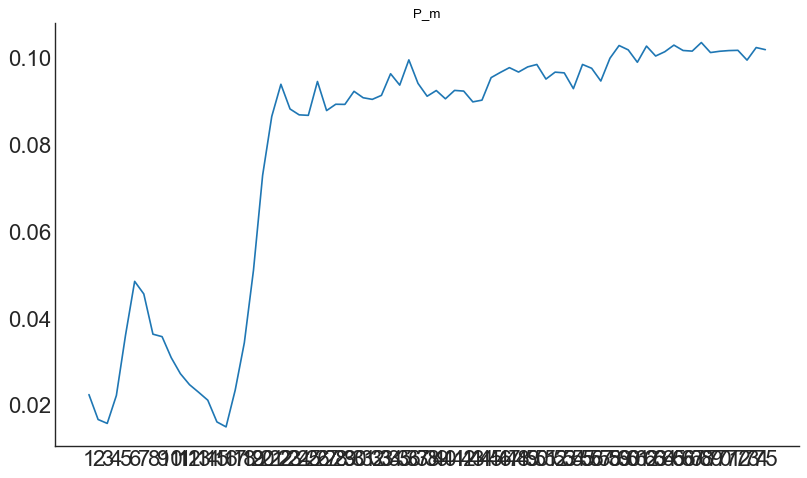

<Figure size 432x288 with 0 Axes>

In [89]:
from matplotlib.pyplot import figure

figure(figsize=(12, 7), dpi=80)

plt.plot([str(i+1) for i in range(last_r)], p_list[:last_r])
plt.title('P_m')
plt.show()
plt.clf()

**Loss change for Model X**

**Input:** loss values for model x  
**Output:** model x loss vs iterations plot

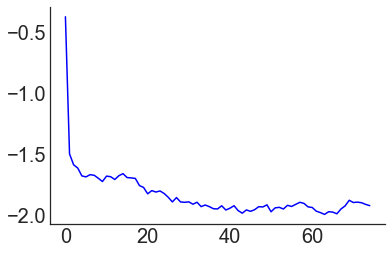

<Figure size 432x288 with 0 Axes>

In [91]:
plt.plot([i for i in range(last_r)], np.array(loss_iter)[:,1][:last_r], color='b')

plt.show()
plt.clf()

**Loss change for Model Y**

**Input:** loss values for model y  
**Output:** model y loss vs iterations plot

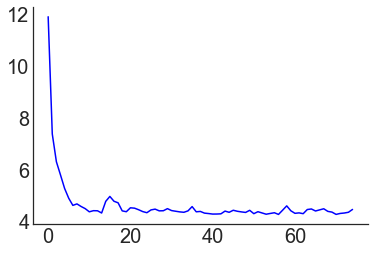

<Figure size 432x288 with 0 Axes>

In [92]:
plt.plot([i for i in range(last_r)], np.array(loss_iter)[:,0][:last_r], color='b')

plt.show()
plt.clf()

**Loss change for Model O**

**Input:** loss values for model o  
**Output:** model o loss vs iterations plot

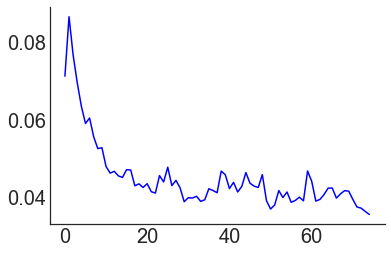

<Figure size 432x288 with 0 Axes>

In [93]:
plt.plot([i for i in range(last_r)], np.array(loss_iter)[:,2][:last_r], color='b')

plt.show()
plt.clf()

**Total loss change**

**Input:** total loss adding all model losses  
**Output:** total loss vs iterations plot

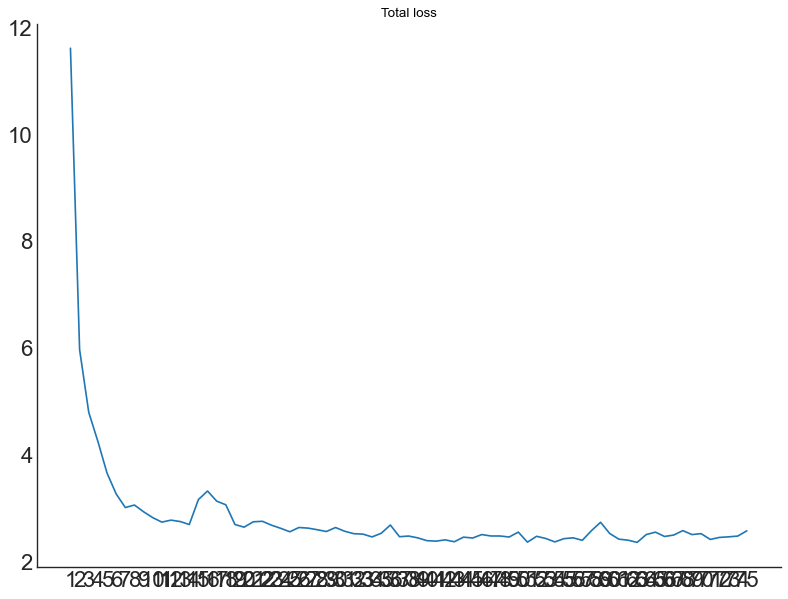

<Figure size 432x288 with 0 Axes>

In [94]:
from matplotlib.pyplot import figure

figure(figsize=(12, 9), dpi=80)
plt.plot([str(i+1) for i in range(last_r)], np.sum(np.array(loss_iter), axis=1)[:last_r])
plt.title('Total loss')
plt.show()
plt.clf()

**All loss changes figure**

**Input:** loss values of different RNN models over iterations  
**Output:** plots showing loss changes for all models and total loss changes together

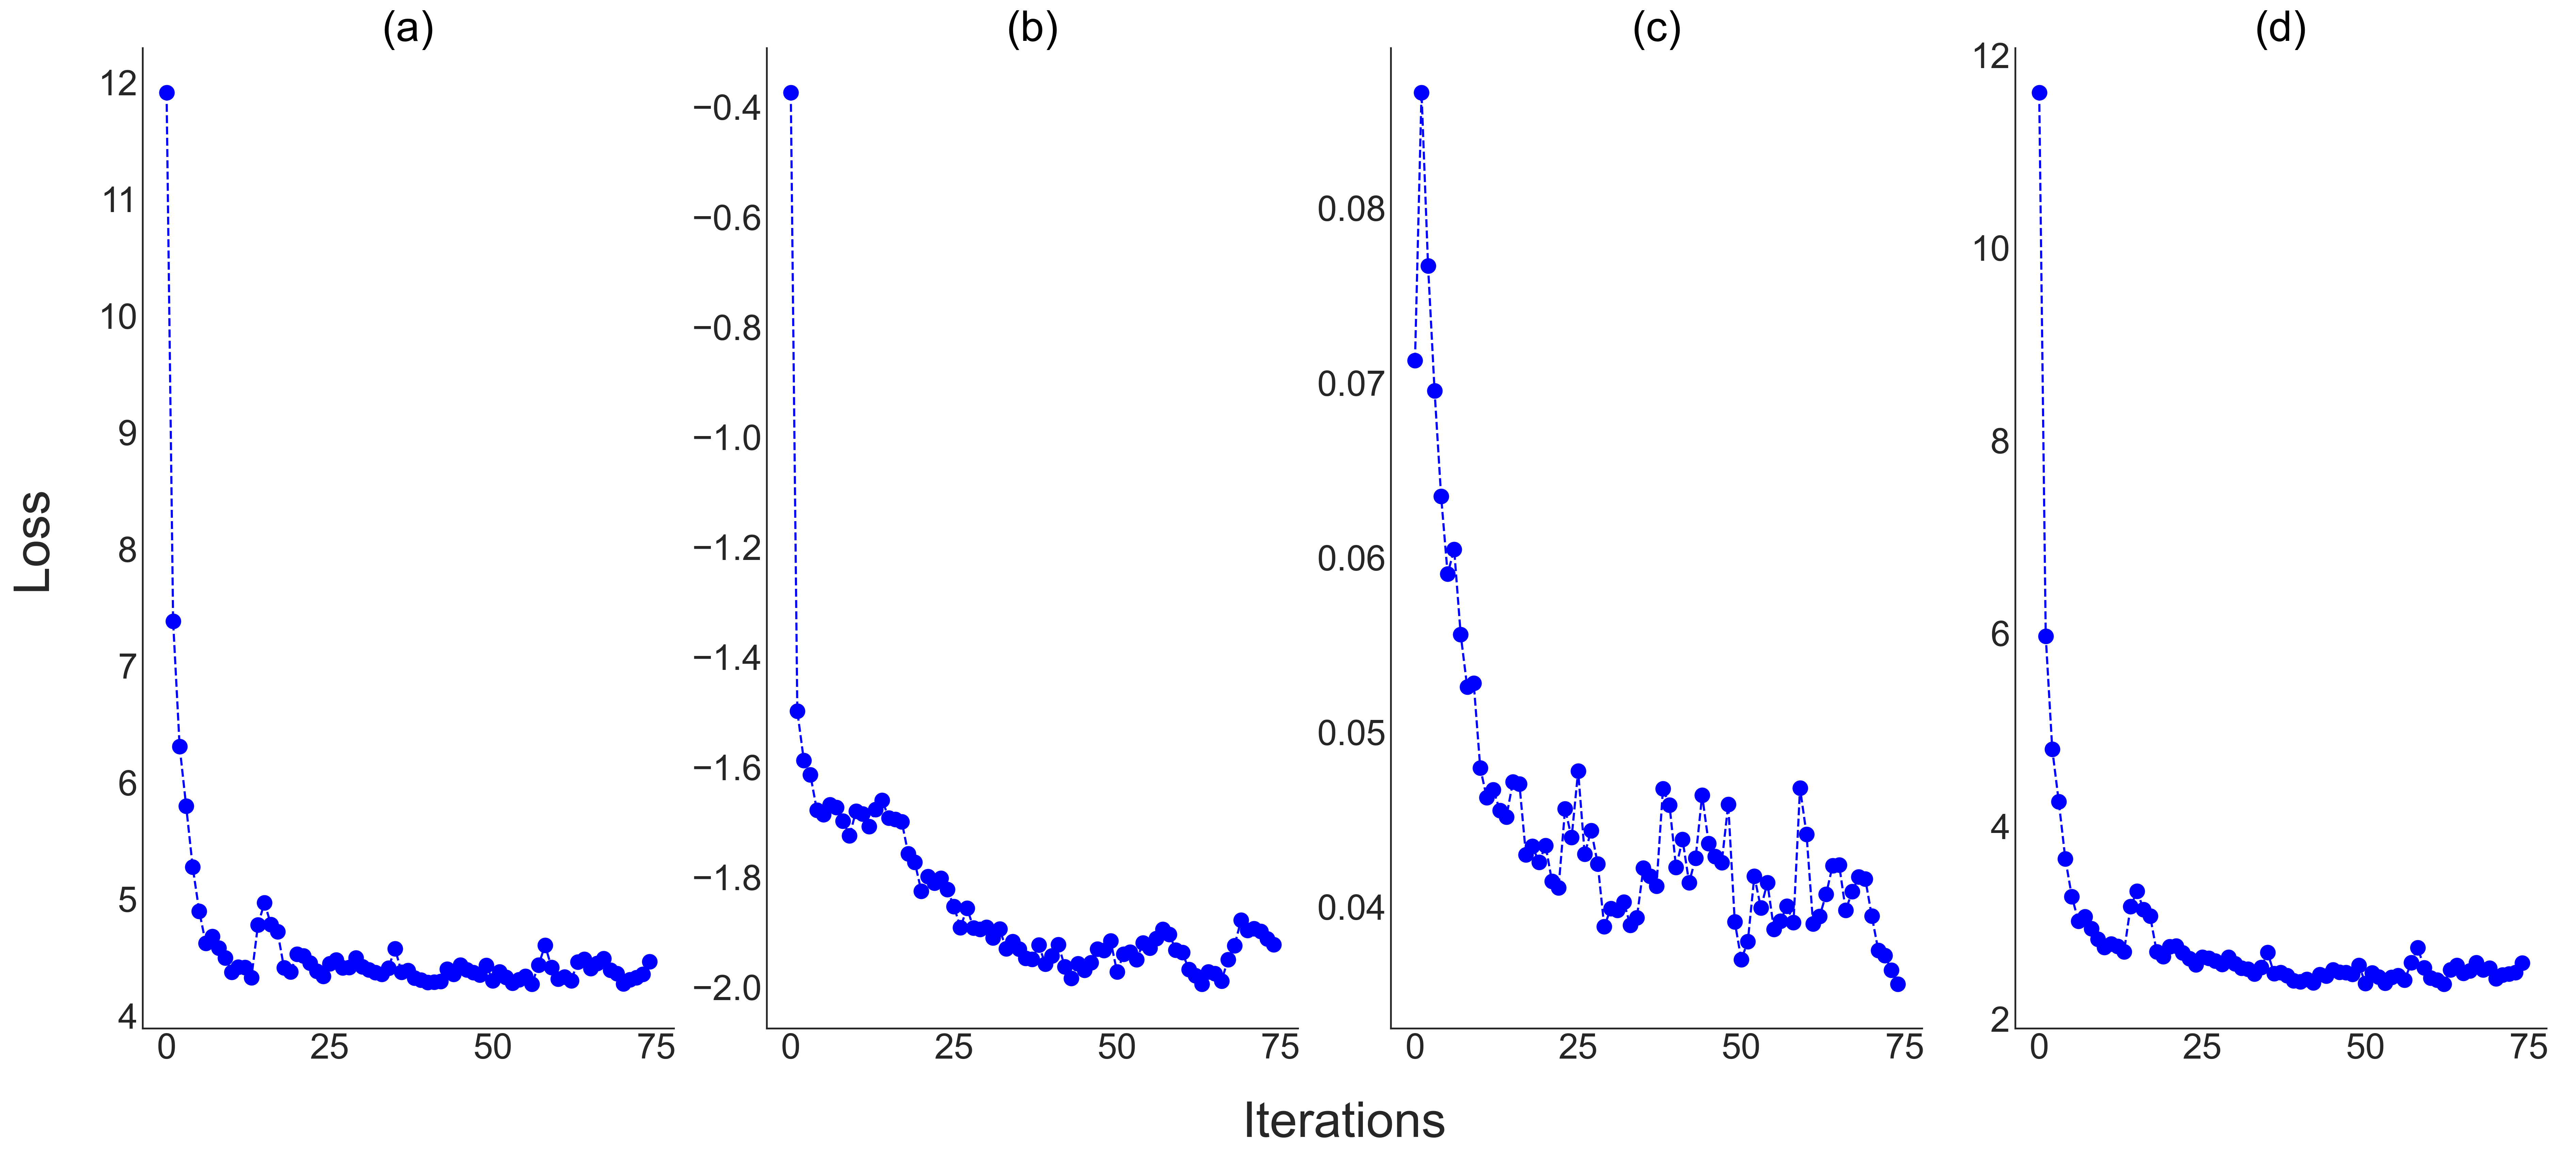

In [95]:
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy


cols = ['(a)','(b)','(c)','(d)']
# rows = ['TS1', 'TS2', 'TS3', 'TS4', 'TS5', 'TS6']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(25, 12), dpi=300)
# plt.setp(axes.flat, xlabel='X-label', ylabel='Y-label')

axes[0].plot(np.array(loss_iter)[:,0], marker='o', markersize=10, linestyle='dashed', color='blue')
axes[1].plot(np.array(loss_iter)[:,1], marker='o', markersize=10, linestyle='dashed', color='blue')
axes[2].plot(np.array(loss_iter)[:,2], marker='o', markersize=10, linestyle='dashed', color='blue')
axes[3].plot(np.sum(np.array(loss_iter), axis=1), marker='o', markersize=10, linestyle='dashed', color='blue')
for n in range(4):
    axes[n].tick_params(labelsize=25)

pad = 5 # in points

for ax, col in zip(axes, cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=30, ha='center', va='baseline')

# for ax, row in zip(axes[:,0], rows):
#     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center')

fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.05, top=0.95, bottom=0.15)
ax=fig.add_subplot(111, frame_on=False)

ax.grid(False)
plt.tick_params(labelcolor='none', bottom=False, left=False)
ax.set_xlabel('Iterations', fontsize=35, labelpad=30)
ax.set_ylabel('Loss', fontsize=35, labelpad=30)
plt.show()
# fig.savefig(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\Loss.pdf',
#            bbox_inches='tight')


## 7. Prediction Problem

### 7.1. Functions

define a function to compute the particle weights for the prediction step  
\begin{equation}
{\phi}_p= \big(\frac{\pi^x({\dot{x}}_{k+1}^{(p)}, {{\theta}_{k+1}^x}^{(n,p)}) 
\,p_m[m_{k}^{(n,p)},m_{k+1}^{(n,p)}]}{\sum_{p=1}^P\pi^x({\dot{x}}_{k+1}^{(p)}, {{\theta}_{k+1}^x}^{(n,p)}) 
\,p_m[m_{k}^{(n,p)},m_{k+1}^{(n,p)}]} \big)
\end{equation}

**Input:** latent state particles obtained using trained RNN models    
**Output:** particle weights for final prediction (get_phi)

In [96]:
def get_phi(m_prev, m_part, Pr_Mk, x_part, dist_x, P):
    #get pi x and pi m to calculate w_phi
    w_x_next=np.array(np.log(dist_x.prob(x_part)+sys.float_info.epsilon)).reshape(P)
    w_m_next=[]
    for p in range(P):
        w_m_next.append( np.log(Pr_Mk[m_prev[p]][m_part[p]]+sys.float_info.epsilon))
    w_xm_next=w_x_next+np.array(w_m_next).reshape(P)
    max_weights_next=np.max(w_xm_next)
    w_xm_next=np.exp((w_xm_next-max_weights_next)).tolist()
    w_phi_next=w_xm_next/np.sum(w_xm_next)
    w_phi_next/=np.sum(w_phi_next)
    return w_phi_next

define a function to obtain the sensor estimates using the ${\phi}$  weights and the RNN models for sensor prediction

**Input:** model y inputs  
**Output:** sensor predictions (get_sensor_est)

In [97]:
def get_sensor_est(ip_y, model_y, Cont_feature, Bin_feature, Cat_feature,
                   Total_features_updated, w_phi, P):
    #get the outputs from model y
    y_est_next=model_y.predict(list((ip_y,np.zeros((P,1,Total_features_updated)))))

    mu_list_next=y_est_next[0].reshape((P,Cont_feature)).astype(np.float64)
    sigma_list_next=y_est_next[1].reshape((P,Cont_feature)).astype(np.float64)


    yb_list_next=y_est_next[2].reshape((P,Bin_feature)).astype(np.float64)

    #Use w_phi to get final k+1 estimation of sensors
    pred_y_next=np.sum(mu_list_next * w_phi[:, None], axis=0).tolist()
    pred_yb_next_=np.sum(yb_list_next*w_phi[:, None], axis=0) 
    pred_yb_next=np.round(pred_yb_next_).tolist() 


    cat_prob_next=np.concatenate([np.sum(y_est_next[3:][i]*
                                         w_phi.reshape(P,1,1), axis=0) 
                                          for i in range(Cat_feature)], axis=0)

    pred_yc_next=np.argmax(cat_prob_next, axis=1).tolist()
    
    return (mu_list_next, sigma_list_next, pred_y_next, pred_yb_next_, 
            pred_yb_next, pred_yc_next, cat_prob_next)
        
   

define functions to estimate the predition intervals for latent state estimates and sensor predictions considering a Gaussian mixture

**Input:** parameters to calculate prediction intervals for degrading state  
**Output:** interval range (get_interval_x)

In [98]:
def get_interval_x(mean, sigma, weight, size=1000, alpha=0.05):
    selection=choice([p for p in range(len(weight))], p=weight, size=size)
    select_mean=mean[selection]
    select_sigma=sigma[selection]
    dist_select=tfp.distributions.TruncatedNormal(select_mean.reshape(-1),
                                                 select_sigma.reshape(-1),
                                                 low=0,high=1)
    samples=np.sort(dist_select.sample(1).numpy().reshape(-1))
    
    return [samples[int(size*alpha/2)],samples[int(size-size*alpha/2)]]
    

**Input:**   parameters to calculate prediction intervals for sensor prediction  
**Output:** interval range (get_interval_y)

In [99]:
def get_interval_y(mean, sigma, weight, size=1000, alpha=0.05, Cont_feature=5):
    selection=choice([p for p in range(len(weight))], p=weight, size=size)
    h=[]
    l=[]
    for i in range(Cont_feature):
        select_mean=mean[selection][:,i]
        select_sigma=sigma[selection][:,i]
        dist_select=tfp.distributions.TruncatedNormal(select_mean.reshape(-1),
                                                 select_sigma.reshape(-1),
                                                 low=0,high=1)
        samples=np.sort(dist_select.sample(1).numpy().reshape(-1))
        l.append(samples[int(size*alpha/2)])
        h.append(samples[int(size-size*alpha/2)])
        
    
    return [l,h]
    

### 7.2. Training Set

Perform the prediction step for the training data using the trained models and the stored particles.  
Do it for all for all iterations and track the performance measure changes for every iteration

**Input:** 
* all the hidden state estimates for all time series and true values upto given time for all sensors  
* trained RNN models

**Output:** prediction of sensors, latent states and hazard rate

* ycont_train
* ybin_train
* ycat_train

* x_particles_train_list

* x_pred_train_list
* m_pred_train_list
* o_pred_train_list

* x_interval_train_list
* y_interval_train_list

* pred_y_train_list
* pred_yb_train_list
* pred_yc_train_list

* w_phi_train_list

In [31]:
chst=time.time()
cont_rmse=[]
bin_acc=[]
cat_acc=[]
X_rmse=[]
O_rmse=[]
dataset_train=dataset[(dataset.N<N) & (dataset.Time>1)].reset_index(drop=True).copy()

for r in range(1,last_r+1):
    ycont_train=[[] for i in range(Cont_feature)]
    ybin_train=[[] for i in range(Bin_feature)]
    ycat_train=[[] for i in range(Cat_feature)]

    x_particles_train_list=[]

    x_pred_train_list=[]
    m_pred_train_list=[]
    o_pred_train_list=[]

    x_interval_train_list=[]
    y_interval_train_list=[]

    pred_y_train_list=[]
    pred_yb_train_list=[]
    pred_yc_train_list=[]

    w_phi_train_list=[]

    for n in range(N):


        start=time.time()
        for given in range(K_n[n]-1):

            x_prev_check=copy.deepcopy(x_store[r-1][n][given])
            m_prev_check=copy.deepcopy(m_store[r-1][n][given])

            (m_part_next, x_part_next, 
             mean_x_next, sigma_x_next, 
             dist_x_next, o_est_next)= get_hidden_particles(m_prev_check, Pr_Mk,
                                                            x_prev_check, model_x,
                                                            model_o, P)       

            w_phi_next=get_phi(m_prev_check, m_part_next, Pr_Mk, 
                               x_part_next, dist_x_next, P)


            #get inputs for model y with x(k+1) and m(k+1)
            ip_y_next=np.concatenate((np.tile(model_y_ip[n][given+1][:Total_features], (P,1,1)), 
                                      x_part_next.reshape((P,1,1)), m_part_next.reshape((P,1,1))) , axis=2)

            (mu_list_next, sigma_list_next, 
             pred_y_next, pred_yb_next_, pred_yb_next,
             pred_yc_next, cat_prob_next)=get_sensor_est(ip_y_next, model_y, Cont_feature, 
                                                         Bin_feature, Cat_feature,
                                                         Total_features_updated, w_phi_next, P)

            pred_m_next=np.round(np.sum(w_phi_next*m_part_next.reshape(P)))
            pred_mean_x_next=np.sum(mean_x_next.reshape(P)*w_phi_next, axis=0)
            pred_o_next=np.sum(o_est_next.reshape(P)*w_phi_next, axis=0)




            # save for results

            for i in range(Cont_feature):
                ycont_train[i].append(np.transpose(mu_list_next)[i])

            for i in range(Bin_feature):
                ybin_train[i].append(pred_yb_next_[i])

            for i in range(Cat_feature):
                ycat_train[i].append(cat_prob_next[i])

            # append results
            w_phi_train_list.append(w_phi_next)
            x_particles_train_list.append(mean_x_next.reshape(-1))
            x_interval_train=get_interval_x(mean_x_next,sigma_x_next, w_phi_next)
            y_interval_train=get_interval_y(mu_list_next, sigma_list_next, 
                                           w_phi_next,Cont_feature=Cont_feature)


            x_interval_train_list.append(x_interval_train)
            y_interval_train_list.append(y_interval_train)

            x_pred_train_list.append(pred_mean_x_next)
            m_pred_train_list.append(pred_m_next)
            o_pred_train_list.append(pred_o_next)
            pred_y_train_list.append(pred_y_next)
            pred_yb_train_list.append(pred_yb_next)
            pred_yc_train_list.append(pred_yc_next)

    cont_rmse.append(mean_squared_error(dataset_train[cont_list], np.array(pred_y_train_list), 
                                            squared=False, multioutput='raw_values').tolist())

    bin_acc.append([accuracy_score(dataset_train[binary_list[i]],
                                   np.array(pred_yb_train_list)[:,i]) 
                    for i in range(Bin_feature)])

    cat_acc.append([accuracy_score(dataset_train[cat_list[i]],
                                   np.array(pred_yc_train_list)[:,i]) 
                    for i in range(Cat_feature)])        
    X_rmse.append(mean_squared_error(dataset_train.X_scaled2, x_pred_train_list, squared=False))
    O_rmse.append(mean_squared_error(dataset_train.Lambda, o_pred_train_list, squared=False))


print(time.time()-chst)

149.65225219726562


**Save all the estimates in dataframes**

**Input:** all the outputs from prediction step for training set  
**Output:** multiple dataframes to store all the results and true values

In [32]:
N_train=dataset_train['N'].tolist()
T_train=dataset_train['Time'].tolist()

# create df for cont sensors
cont_sensor_df_list_train=[pd.DataFrame(columns=['N', 'Time', 'True', 'Est', 
                                           'sigma_est_l', 'sigma_est_h']+
                                          ['P'+str(p+1) for p in range(P)]+
                                          ['W'+str(p+1) for p in range(P)]) 
                     for i in range(Cont_feature)]
for i in range(Cont_feature):
    cont_sensor_df_list_train[i]['N']             =copy.deepcopy(N_train)
    cont_sensor_df_list_train[i]['Time']          =copy.deepcopy(T_train)
    cont_sensor_df_list_train[i]['Z_val']         =dataset_train[Z_cols[i]].copy()   
    cont_sensor_df_list_train[i]['True']          =dataset_train[cont_list[i]].tolist()
    cont_sensor_df_list_train[i]['Est']           =np.array(pred_y_train_list)[:,i]
    cont_sensor_df_list_train[i][['sigma_est_l',
                           'sigma_est_h']]  =np.array(y_interval_train_list)[:,:,i]
    cont_sensor_df_list_train[i][['P'+str(p+1) for p in range(P)]]=np.array(ycont_train[i])
    cont_sensor_df_list_train[i][['W'+str(p+1) for p in range(P)]]=np.array(w_phi_train_list)
#     cont_sensor_df_list_train[i].to_csv(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\Cont_Sensor_'+cont_list[i]+'.csv', index=False)


# create df for bin sensors
bin_sensor_df_list_train=[pd.DataFrame(columns=['N', 'Time', 'True', 'Est', 'Bin_Prob']) 
                for i in range(Bin_feature)]

for i in range(Bin_feature):
    bin_sensor_df_list_train[i]['N']       =copy.deepcopy(N_train)
    bin_sensor_df_list_train[i]['Time']    =copy.deepcopy(T_train)
    bin_sensor_df_list_train[i]['Z_val']   =dataset_train[Z_cols[Cont_feature+i]].copy()   
    bin_sensor_df_list_train[i]['True']    =dataset_train[binary_list[i]].tolist()
    bin_sensor_df_list_train[i]['Est']     =np.array(pred_yb_train_list)[:,i]
    bin_sensor_df_list_train[i]['Bin_Prob']=np.array(ybin_train[i])
    bin_sensor_df_list_train[i]['True_Prob']=((1-dataset_train['M'])*(0.85)+
                                       dataset_train['M']*0.15 if i<2 
                                       else (1-dataset_train['M'])*(0.9)+
                                       dataset_train['M']*0.1)
#     bin_sensor_df_list[i].to_csv(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\Bin_Sensor_'+binary_list[i]+'.csv', index=False)


# create df for cat sensors
cat_sensor_df_list_train=[pd.DataFrame(columns=['N', 'Time', 'True', 'Est']+
                                 ['Prob_Class_'+str(c) for c in range(cat_l_updated[i])]) 
                for i in range(Cat_feature)]

for i in range(Cat_feature):
    cat_sensor_df_list_train[i]['N']       =copy.deepcopy(N_train)
    cat_sensor_df_list_train[i]['Time']    =copy.deepcopy(T_train)
    cat_sensor_df_list_train[i]['Z_val']   =dataset_train[Z_cols[Cont_feature+Bin_feature+i]].copy()   
    cat_sensor_df_list_train[i]['True']    =dataset_train[cat_list[i]].tolist()
    cat_sensor_df_list_train[i]['Est']     =np.array(pred_yc_train_list)[:,i]
    cat_sensor_df_list_train[i][['Prob_Class_'+str(c) for c in range(cat_l_updated[i])]]=np.array(ycat_train[i])
    cat_sensor_df_list_train[i]['Est_prob']=np.sum((cat_sensor_df_list_train[i]['True']==c)* 
                                                    (cat_sensor_df_list_train[i]['Prob_Class_'+str(c)]) 
                                                    for c in range(cat_l_updated[i]))
    cat_sensor_df_list_train[i]['True_prob']=(((dataset_train.X>=0.5)*
                                       Pr_YCk_h[dataset_train.M.astype(int),
                                                i,cat_sensor_df_list_train[i]['True']-1]+
                                       (dataset_train.X<0.5)*
                                       Pr_YCk_l[dataset_train.M.astype(int),
                                                i,cat_sensor_df_list_train[i]['True']-1]) if cat_l[i]!=cat_l_updated[i] else 
                                              ((dataset_train.X>=0.5)*
                                       Pr_YCk_h[dataset_train.M.astype(int),
                                                i,cat_sensor_df_list_train[i]['True']]+
                                       (dataset_train.X<0.5)*
                                       Pr_YCk_l[dataset_train.M.astype(int),
                                                i,cat_sensor_df_list_train[i]['True']]))
#     cat_sensor_df_list[i].to_csv(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\Cat_Sensor_'+cat_list[i]+'.csv', index=False)


# create df for hidden states
hidden_df_train=pd.DataFrame(columns=['N', 'Time', 'X_true', 
                                     'M_true', 'O_true', 'Lambda_true', 
                                     'X_est', 'X_sigma_est_l', 'X_sigma_est_h',
                                     'M_est', 'Lambda_est'])





hidden_df_train['X_est']                         =x_pred_train_list
hidden_df_train[['X_sigma_est_l', 
                'X_sigma_est_h']]               =np.array(x_interval_train_list)
hidden_df_train['M_est']                         =m_pred_train_list
hidden_df_train['Lambda_est']                    =o_pred_train_list
# hidden_df_train[['P'+str(p+1) for p in range(P)]]=np.array(x_particles_train_list)
# hidden_df_train[['W'+str(p+1) for p in range(P)]]=np.array(w_phi_train_list)
hidden_df_train[['N', 'Time', 'X_true',
                'M_true', 'O_true', 
                'Lambda_true']]                 =np.array(dataset_train
                                                  [['N', 'Time','X_scaled2',
                                                    'M', 'O', 'Lambda']].reset_index
                                                  (drop=True).copy())
# hidden_df_train.to_csv(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\Hidden_states_train.csv', index=False)


Store the performance changes over iterations

**Input:** performance measures for all iterations for all time series from training set  
**Output:** multiple lists of performance change over iterations for all time series

In [33]:
rmse_change_cont=pd.DataFrame(cont_rmse, columns=[cont_list])
# rmse_change_cont.to_csv(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\rmse_change_cont.csv', index=False)

acc_change_bin=pd.DataFrame(data=np.array(bin_acc),columns=binary_list)

# acc_change_bin.to_csv(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\acc_change_bin.csv', index=False)

acc_change_cat=pd.DataFrame(data=np.array(cat_acc),columns=cat_list)
# acc_change_cat.to_csv(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\acc_change_cat.csv', index=False)

X_rmse_df=pd.DataFrame(X_rmse, columns=['X_RMSE'])
# X_rmse_df.to_csv(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\RMSE_X.csv', index=False)

loss_df=pd.DataFrame(loss_iter, columns=['Y_loss', 'X_loss','O_loss'])
# loss_df.to_csv(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\loss_df.csv', index=False)

p_df=pd.DataFrame(p_list, columns=['p_m'])
# p_df.to_csv(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\p_df.csv', index=False)


### 7.3. Testing Set

**Get the hidden particles for all time for test set**

**Input:**   
* trained RNN models and weights
* true values of sensors upto a given time


**Output:** particles for all latent states to be used for final prediction
* x_test_store
* m_test_store
* o_test_store

In [101]:
x_test_store=[[[] for k in range(K_n[n])] for n in range(N,N_sim)]
m_test_store=[[[] for k in range(K_n[n])] for n in range(N,N_sim)]
o_test_store=[[[] for k in range(K_n[n])] for n in range(N,N_sim)]


for n in range(N,N+N):
    m_p_replaced_test=choice([0,1],p=[1,0],size=P)
    x_p_replaced_test=np.ones(P)
    for k in range(K_n[n]):
        
        (m_part_test, x_part_test, 
             mean_x_test, sigma_x_test, 
             dist_x_test, o_est_test)=get_hidden_particles(m_p_replaced_test, Pr_Mk, 
                                                           x_p_replaced_test, 
                                                           model_x, model_o, P)

        w_p_test=get_particle_weights(x_part_test,m_part_test,
                                      o_est_test,model_y,
                                      model_y_ip[n][k][:Total_features],
                                      model_y_op[n][k], model_o_op[n][k],P,
                                      Cont_feature, Bin_feature, Cat_feature)


        max_weights_test=np.max(w_p_test)
        w_p_test=np.exp((w_p_test-max_weights_test)).tolist()
        sum_weights_test=np.sum(w_p_test)
        prob_w_test=w_p_test/np.sum(w_p_test)
        prob_w_test/=np.sum(prob_w_test)


        replace_ind_test=choice([p for p in range(P)], p=prob_w_test, size=P)
        x_p_replaced_test=x_part_test.reshape(P)[replace_ind_test]
        m_p_replaced_test=m_part_test.reshape(P)[replace_ind_test]
        o_replaced_test=o_est_test.reshape(P)[replace_ind_test]

        x_test_store[n-N][k]=copy.deepcopy(x_p_replaced_test.tolist())
        m_test_store[n-N][k]=copy.deepcopy(m_p_replaced_test.tolist())
        o_test_store[n-N][k]=copy.deepcopy(o_replaced_test.tolist())

        

**Get the prediction for the test set**

**Input:** 
* all the hidden state estimates for all time series and true values upto given time for all sensors  
* trained RNN models

**Output:** prediction of sensors, latent states and hazard rate
* ycont
* ybin
* ycat

* x_particles_test_list

* x_pred_test_list
* m_pred_test_list
* o_pred_test_list

* x_interval_test_list
* y_interval_test_list

* pred_y_test_list
* pred_yb_test_list
* pred_yc_test_list

* w_phi_test_list

In [102]:
check_time=time.time()


ycont=[[] for i in range(Cont_feature)]
ybin=[[] for i in range(Bin_feature)]
ycat=[[] for i in range(Cat_feature)]

x_particles_list=[]

x_pred_test_list=[]
m_pred_test_list=[]
o_pred_test_list=[]

x_interval_test_list=[]
y_interval_test_list=[]

pred_y_test_list=[]
pred_yb_test_list=[]
pred_yc_test_list=[]

w_phi_test_list=[]

for n in range(N,N+N):
    

    start=time.time()
    for given in range(K_n[n]-1):

        x_prev_check=copy.deepcopy(x_test_store[n-N][given])
        m_prev_check=copy.deepcopy(m_test_store[n-N][given])
#         m_prev_check=choice([0,1],size=P, p=[0.5,0.5]).tolist() 

        (m_part_next, x_part_next, 
         mean_x_next, sigma_x_next, 
         dist_x_next, o_est_next)= get_hidden_particles(m_prev_check, Pr_Mk,
                                                        x_prev_check, model_x,
                                                        model_o, P)       

        w_phi_next=get_phi(m_prev_check, m_part_next, Pr_Mk, 
                           x_part_next, dist_x_next, P)


        #get inputs for model y with x(k+1) and m(k+1)
        ip_y_next=np.concatenate((np.tile(model_y_ip[n][given+1][:Total_features], (P,1,1)), 
                                  x_part_next.reshape((P,1,1)), m_part_next.reshape((P,1,1))) , axis=2)

        (mu_list_next, sigma_list_next, 
         pred_y_next, pred_yb_next_, pred_yb_next,
         pred_yc_next, cat_prob_next)=get_sensor_est(ip_y_next, model_y, Cont_feature, 
                                                     Bin_feature, Cat_feature,
                                                     Total_features_updated, w_phi_next, P)
        
        pred_m_next=np.round(np.sum(w_phi_next*m_part_next.reshape(P)))
        pred_mean_x_next=np.sum(mean_x_next.reshape(P)*w_phi_next, axis=0)

        pred_o_next=np.sum(o_est_next.reshape(P)*w_phi_next, axis=0)
        # save for results

        
        for i in range(Cont_feature):
            ycont[i].append(np.transpose(mu_list_next)[i])
       
        
        for i in range(Bin_feature):
            ybin[i].append(pred_yb_next_[i])
        
        for i in range(Cat_feature):
            ycat[i].append(cat_prob_next[i])
       
        # append results
        w_phi_test_list.append(w_phi_next)
        x_particles_list.append(mean_x_next.reshape(-1))
        x_interval_test=get_interval_x(mean_x_next,sigma_x_next, w_phi_next)
        y_interval_test=get_interval_y(mu_list_next, sigma_list_next, 
                                       w_phi_next,Cont_feature=Cont_feature)
        

        x_interval_test_list.append(x_interval_test)
        y_interval_test_list.append(y_interval_test)
        
        x_pred_test_list.append(pred_mean_x_next)
        m_pred_test_list.append(pred_m_next)
        o_pred_test_list.append(pred_o_next)
        pred_y_test_list.append(pred_y_next)
        pred_yb_test_list.append(pred_yb_next)
        pred_yc_test_list.append(pred_yc_next)

print(time.time()-check_time)

219.72597980499268


**Save all the estimates from test data in multiple dataframes**

**Input:** all the outputs from prediction step for test set  
**Output:** multiple dataframes to store all the results and true values

In [103]:
dataset_test=dataset[(dataset.N>=N) & (dataset.Time>1) & (dataset.N<N+N)].reset_index(drop=True).copy()
N_test=dataset_test['N'].tolist()
T_test=dataset_test['Time'].tolist()

# create df for cont sensors
cont_sensor_df_list=[pd.DataFrame(columns=['N', 'Time', 'Z_val', 'True', 'Est', 
                                           'sigma_est_l', 'sigma_est_h']+
                                          ['P'+str(p+1) for p in range(P)]+
                                          ['W'+str(p+1) for p in range(P)]) 
                     for i in range(Cont_feature)]
for i in range(Cont_feature):
    cont_sensor_df_list[i]['N']             =copy.deepcopy(N_test)
    cont_sensor_df_list[i]['Time']          =copy.deepcopy(T_test)
    cont_sensor_df_list[i]['Z_val']         =dataset_test[Z_cols[i]].copy()   
    cont_sensor_df_list[i]['True']          =dataset_test[cont_list[i]].tolist()
    cont_sensor_df_list[i]['Est']           =np.array(pred_y_test_list)[:,i]
    cont_sensor_df_list[i][['sigma_est_l',
                           'sigma_est_h']]  =np.array(y_interval_test_list)[:,:,i]
    cont_sensor_df_list[i][['P'+str(p+1) for p in range(P)]]=np.array(ycont[i])
    cont_sensor_df_list[i][['W'+str(p+1) for p in range(P)]]=np.array(w_phi_test_list)
#     cont_sensor_df_list[i].to_csv(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\Cont_Sensor_'+cont_list[i]+'.csv', index=False)


# create df for bin sensors
bin_sensor_df_list=[pd.DataFrame(columns=['N', 'Time', 'Z_val', 'True', 'Est', 'Bin_Prob']) 
                for i in range(Bin_feature)]

for i in range(Bin_feature):
    bin_sensor_df_list[i]['N']       =copy.deepcopy(N_test)
    bin_sensor_df_list[i]['Time']    =copy.deepcopy(T_test)
    bin_sensor_df_list[i]['Z_val']   =dataset_test[Z_cols[Cont_feature+i]].copy()   
    bin_sensor_df_list[i]['True']    =dataset_test[binary_list[i]].tolist()
    bin_sensor_df_list[i]['Est']     =np.array(pred_yb_test_list)[:,i]
    bin_sensor_df_list[i]['Bin_Prob']=np.array(ybin[i])
    bin_sensor_df_list[i]['True_Prob']=((1-dataset_test['M'])*(0.85)+
                                       dataset_test['M']*0.15 if i<2 
                                       else (1-dataset_test['M'])*(0.9)+
                                       dataset_test['M']*0.1) * bin_sensor_df_list[i]['Z_val']
#     bin_sensor_df_list[i].to_csv(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\Bin_Sensor_'+binary_list[i]+'.csv', index=False)


# create df for cat sensors
cat_sensor_df_list=[pd.DataFrame(columns=['N', 'Time', 'Z_val', 'True', 'Est']+
                                 ['Prob_Class_'+str(c) for c in range(cat_l_updated[i])]) 
                for i in range(Cat_feature)]

for i in range(Cat_feature):
    cat_sensor_df_list[i]['N']       =copy.deepcopy(N_test)
    cat_sensor_df_list[i]['Time']    =copy.deepcopy(T_test)
    cat_sensor_df_list[i]['Z_val']   =dataset_test[Z_cols[Cont_feature+Bin_feature+i]].copy()   
    cat_sensor_df_list[i]['True']    =dataset_test[cat_list[i]].tolist()
    cat_sensor_df_list[i]['Est']     =np.array(pred_yc_test_list)[:,i]
    cat_sensor_df_list[i][['Prob_Class_'+str(c) for c in range(cat_l_updated[i])]]=np.array(ycat[i])
    cat_sensor_df_list[i]['Est_prob']=np.sum((cat_sensor_df_list[i]['True']==c)* 
                                                    (cat_sensor_df_list[i]['Prob_Class_'+str(c)]) 
                                                    for c in range(cat_l_updated[i]))
    cat_sensor_df_list[i]['True_prob']=(((dataset_test.X>=0.5)* Pr_YCk_h[dataset_test.M.astype(int),
                                                                         i,cat_sensor_df_list[i]['True']-1]+
                                       (dataset_test.X<0.5)* Pr_YCk_l[dataset_test.M.astype(int),
                                                                      i,cat_sensor_df_list[i]['True']-1]) 
                                        if cat_l[i]!=cat_l_updated[i] else 
                                        ((dataset_test.X>=0.5)* Pr_YCk_h[dataset_test.M.astype(int),
                                                                         i,cat_sensor_df_list[i]['True']]+
                                         (dataset_test.X<0.5)* Pr_YCk_l[dataset_test.M.astype(int),
                                                                        i,cat_sensor_df_list[i]['True']])) * cat_sensor_df_list[i]['Z_val']
#     cat_sensor_df_list[i].to_csv(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\Cat_Sensor_'+cat_list[i]+'.csv', index=False)

# create df for hidden states
hidden_df_test=pd.DataFrame(columns=['N', 'Time', 'X_true', 
                                     'M_true', 'O_true', 'Lambda_true', 
                                     'X_est', 'X_sigma_est_l', 'X_sigma_est_h',
                                     'M_est', 'Lambda_est']+
                                    ['P'+str(p+1) for p in range(P)]+
                                    ['W'+str(p+1) for p in range(P)])





hidden_df_test['X_est']                         =x_pred_test_list
hidden_df_test[['X_sigma_est_l', 
                'X_sigma_est_h']]               =np.array(x_interval_test_list)
hidden_df_test['M_est']                         =m_pred_test_list
hidden_df_test['Lambda_est']                    =o_pred_test_list
hidden_df_test[['P'+str(p+1) for p in range(P)]]=np.array(x_particles_list)
hidden_df_test[['W'+str(p+1) for p in range(P)]]=np.array(w_phi_test_list)
hidden_df_test[['N', 'Time', 'X_true',
                'M_true', 'O_true', 
                'Lambda_true']]                 =np.array(dataset_test
                                                  [['N', 'Time','X_scaled2',
                                                    'M', 'O', 'Lambda']].reset_index
                                                  (drop=True).copy())
# hidden_df_test.to_csv(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\Hidden_states.csv', index=False)




Store the performance measures for the test data for every time series in test data.  
Filter these to select time series with best results

**Input:** predictions from all time series from test set  
**Output:** multiple lists of performance measures with scores for each time series separately

In [104]:
RMSE_list_test=[]
for n in range(N,N+N):
    RMSE_list_test.append(mean_squared_error(dataset_test[dataset_test.N==n][cont_list], 
                                        np.array(pred_y_test_list)[dataset_test[
                                            dataset_test.N==n].index], 
                                        squared=False, multioutput='raw_values').tolist())
ACC_yb_list_test=[]
for n in range(N,N+N):
    ACC_yb_list_test.append([accuracy_score(dataset_test[dataset_test.N==n][binary_list[i]], 
                                       np.array(pred_yb_test_list)[dataset_test[
                                            dataset_test.N==n].index,i]) 
                        for i in range(Bin_feature)])
ACC_yc_list_test=[]
for n in range(N,N+N):
    ACC_yc_list_test.append([accuracy_score(dataset_test[dataset_test.N==n][cat_list[i]], 
                                       np.array(pred_yc_test_list)[dataset_test[
                                            dataset_test.N==n].index,i])
                          for i in range(Cat_feature)])
RMSE_list_X=[]
for n in range(N,N+N):
    RMSE_list_X.append(mean_squared_error(hidden_df_test[hidden_df_test.N==n]['X_true'],
                                          hidden_df_test[hidden_df_test.N==n]['X_est'], 
                                          squared=False))

RMSE_list_O=[]
for n in range(N,N+N):
    RMSE_list_O.append(mean_squared_error(hidden_df_test[hidden_df_test.N==n]['Lambda_true'],
                                          hidden_df_test[hidden_df_test.N==n]['Lambda_est'], 
                                          squared=False))




## 8. Results

### 8.1. Train vs Test Performance

Compare the results of training data and test data in a dataframe

**Input:** train & test performance measures  
**Output:** train vs test performance comparison

In [38]:
train_vs_test=pd.DataFrame(data={'dataset':['Train', 'Test'],})


train_vs_test[cont_list]=np.concatenate([cont_rmse[-1],
                                           np.mean(np.array(RMSE_list_test), axis=0)], axis=0).reshape(2,Cont_feature)
train_vs_test[binary_list]=np.array([bin_acc[-1],np.mean(ACC_yb_list_test, axis=0)])
train_vs_test[cat_list]=np.array([cat_acc[-1],np.mean(ACC_yc_list_test, axis=0)])

train_vs_test['X']=[X_rmse[-1], np.mean(RMSE_list_X)]
train_vs_test['M']=[accuracy_score(hidden_df_train.M_true, hidden_df_train.M_est), 
                      accuracy_score(hidden_df_test.M_true, hidden_df_test.M_est)]

# train_vs_test.to_csv(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\performance_train_test.csv', index=False)
train_vs_test

,dataset,Y_i0,Y_i1,Y_i2,Y_i3,Y_i4,Y_i5,Y_i6,Y_i7,Y_i8,Y_i9,Y_i10,Y_i11,Y_i12,Y_i13,X,M
0,Train,0.107196,0.102160,0.092515,0.095021,0.095598,0.918919,0.871622,0.912162,0.912162,0.864865,0.851351,0.851351,0.831081,0.797297,0.149568,0.709459
1,Test,0.160188,0.153006,0.149296,0.145787,0.149623,0.756214,0.675380,0.745153,0.810336,0.555122,0.546069,0.549423,0.525523,0.477438,0.146505,0.733333


### 8.2. 95% Prediction Interval Train vs Test

**Input:** prediction interval range for train and test (continuous sensors)  
**Output:** 95% prediction coverage by training and testing estimates

In [39]:
Pred_interval=pd.DataFrame(data={'dataset':['Train', 'Test'],})
Pred_interval[cont_list]=np.array([[len(cont_sensor_df_list[i][(cont_sensor_df_list[i]['True']>=
                                                                cont_sensor_df_list[i]['sigma_est_l']) & 
                                                               (cont_sensor_df_list[i]['True']<=
                                                                cont_sensor_df_list[i]['sigma_est_h'])])/
                                    len(cont_sensor_df_list[i]) 
                                    for i in range(Cont_feature)], 
                                   [len(cont_sensor_df_list_train[i][(cont_sensor_df_list_train[i]['True']>=
                                                                      cont_sensor_df_list_train[i]['sigma_est_l']) & 
                                                                     (cont_sensor_df_list_train[i]['True']<= 
                                                                      cont_sensor_df_list_train[i]['sigma_est_h'])])/
                                    len(cont_sensor_df_list_train[i]) 
                                    for i in range(Cont_feature)]])
Pred_interval

,dataset,Y_i0,Y_i1,Y_i2,Y_i3,Y_i4
0,Train,0.527778,0.550000,0.622222,0.583333,0.616667
1,Test,0.709459,0.716216,0.763514,0.722973,0.736486


### 8.3. Performance Change Over Iterations

**RMSE change over iterations for continuous sensors**

**Input:** RMSE change over iterations for continuous sensors  
**Output:** RMSE vs iterations for continuous sensors

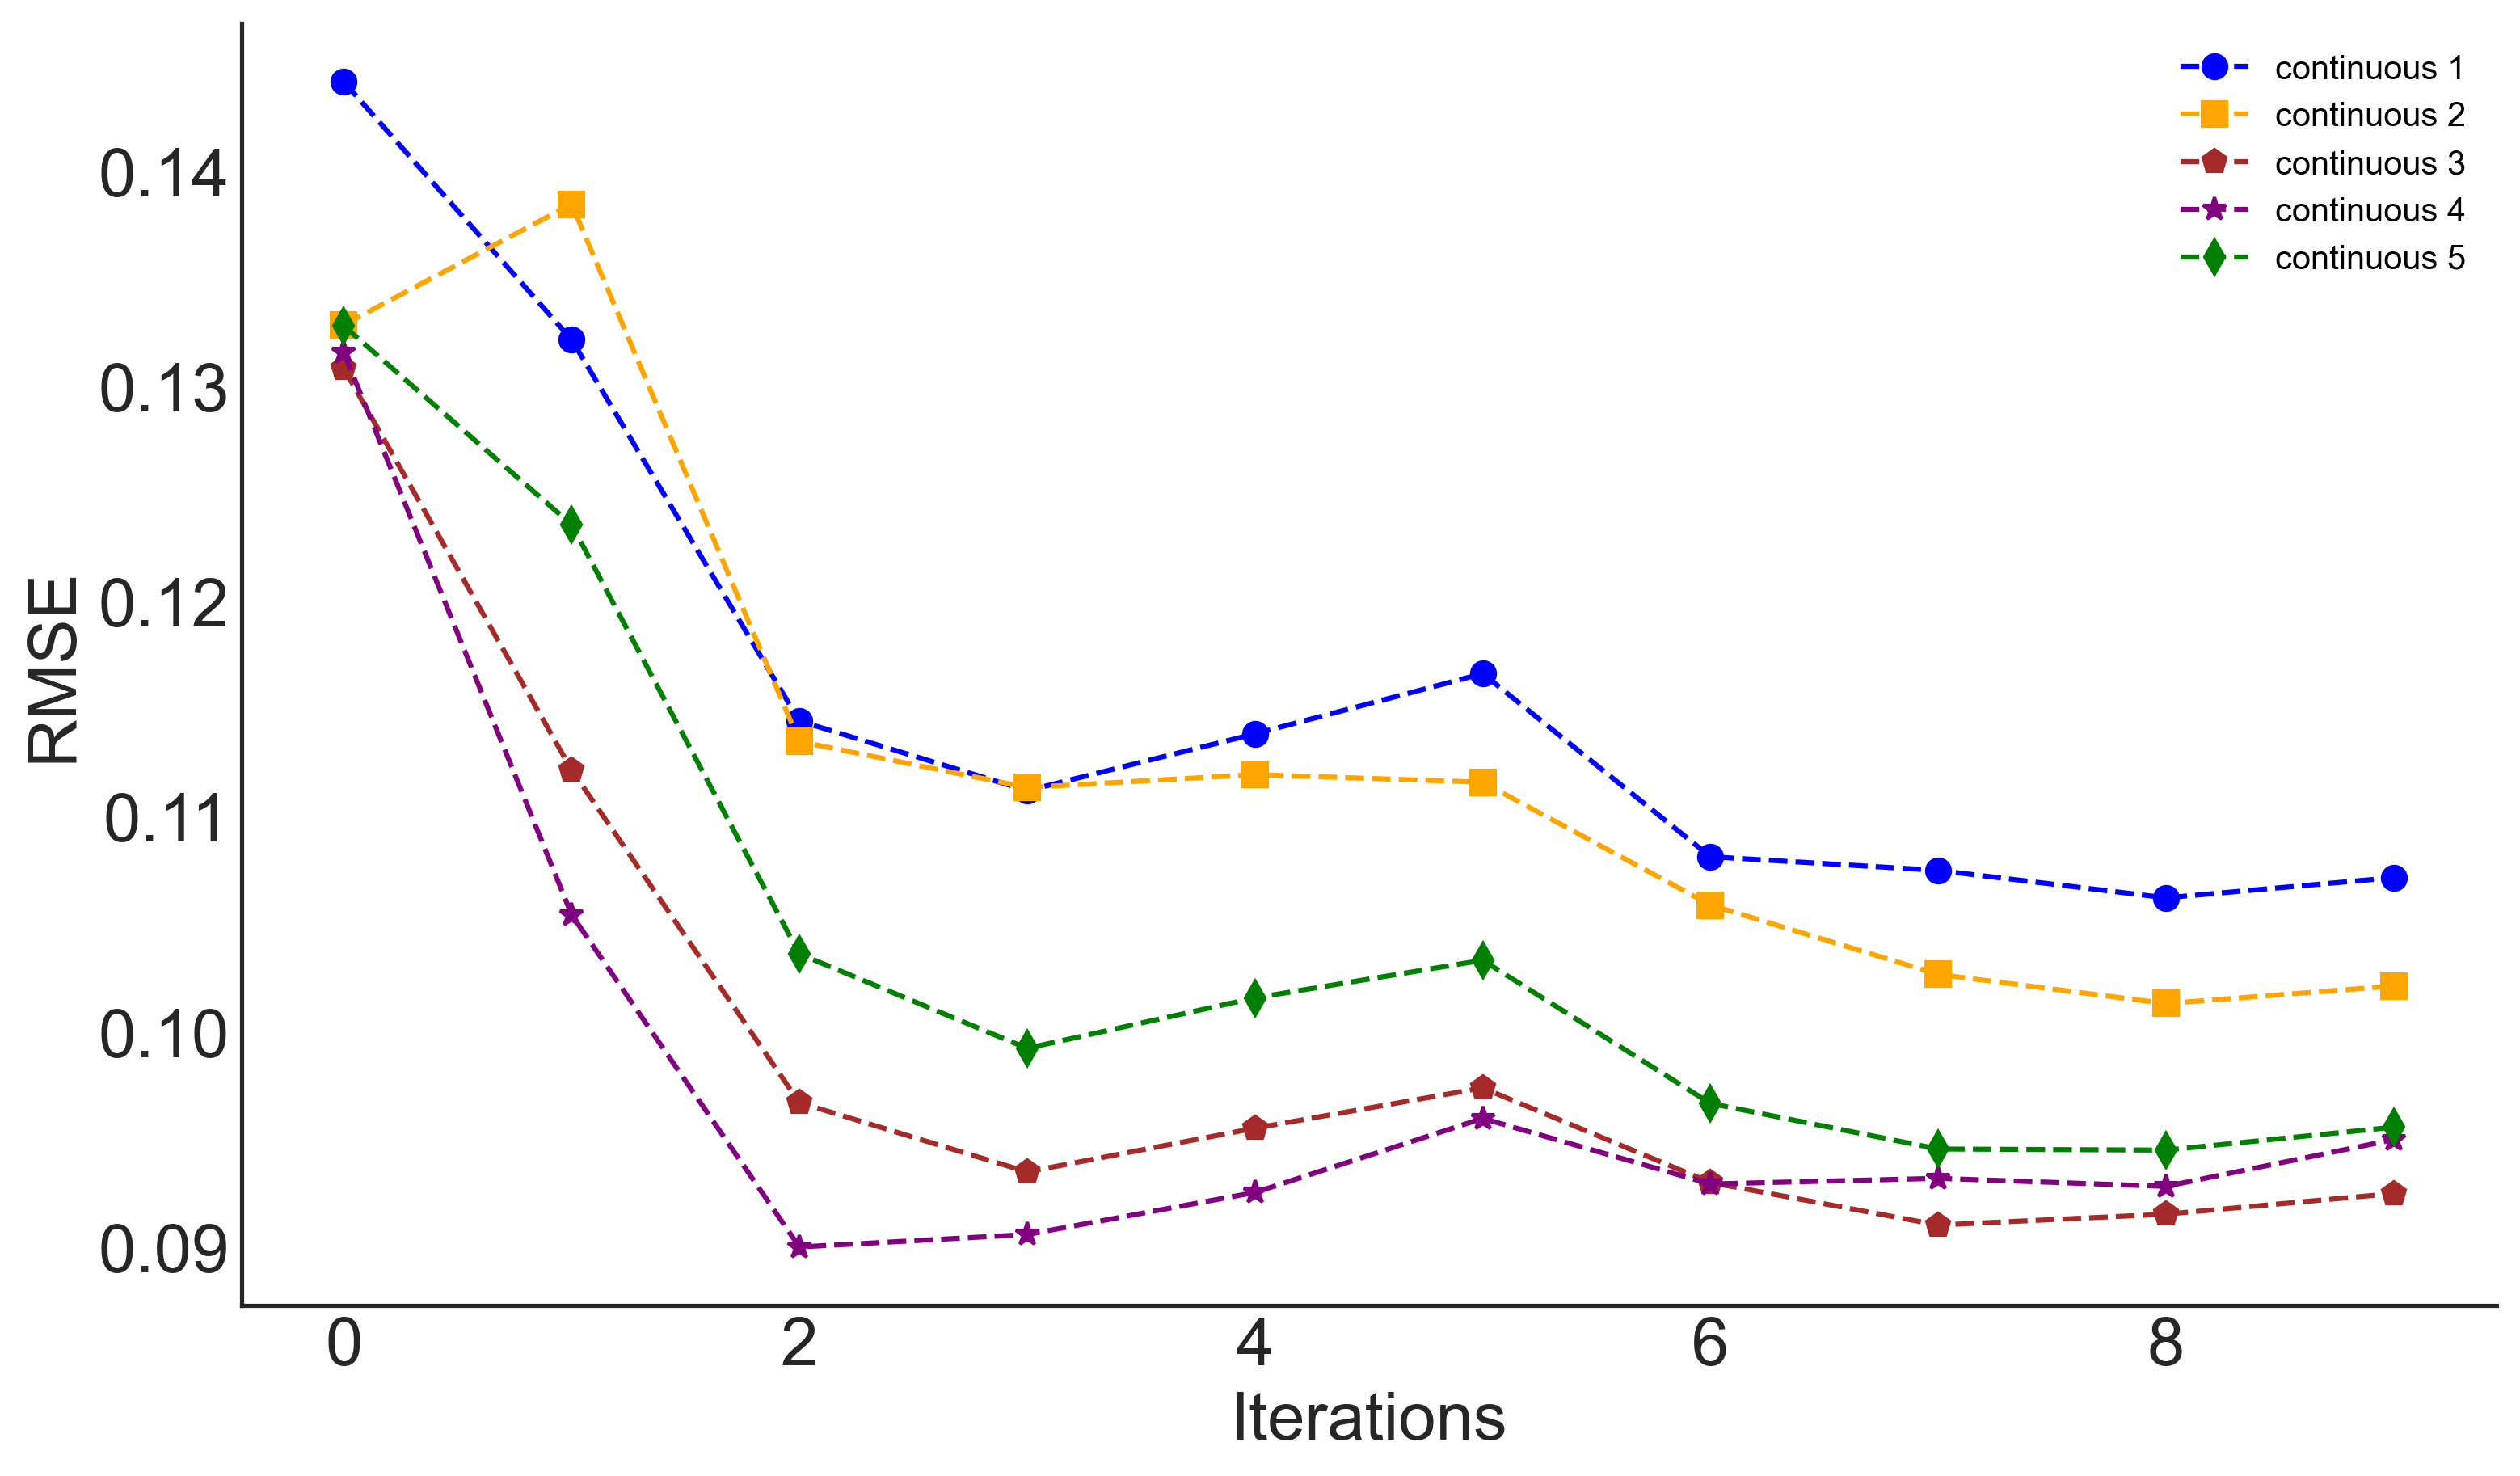

<Figure size 432x288 with 0 Axes>

In [40]:
figure(figsize=(12, 7), dpi=300)
colors=['blue', 'orange', 'brown', 'purple', 'green']
markers=['o', 's', 'p', '*', 'd']
for i in range(Cont_feature):
    plt.plot(np.array(cont_rmse)[:,i], color=colors[i], linewidth=1.5, marker=markers[i],
             markersize=7, linestyle='dashed', label='continuous '+str(i+1))


plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend(loc=1, bbox_to_anchor=(1,1))
# plt.yticks(np.arange(0.05,0.2, step=0.05))

plt.show()
# plt.savefig(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\RMSE_cont.pdf',
#            bbox_inches='tight')
plt.clf()


**RMSE change over iterations for continuous degradation state**

**Input:** RMSE change over iterations for degrading state  
**Output:** RMSE vs iterations for continuous degrading state

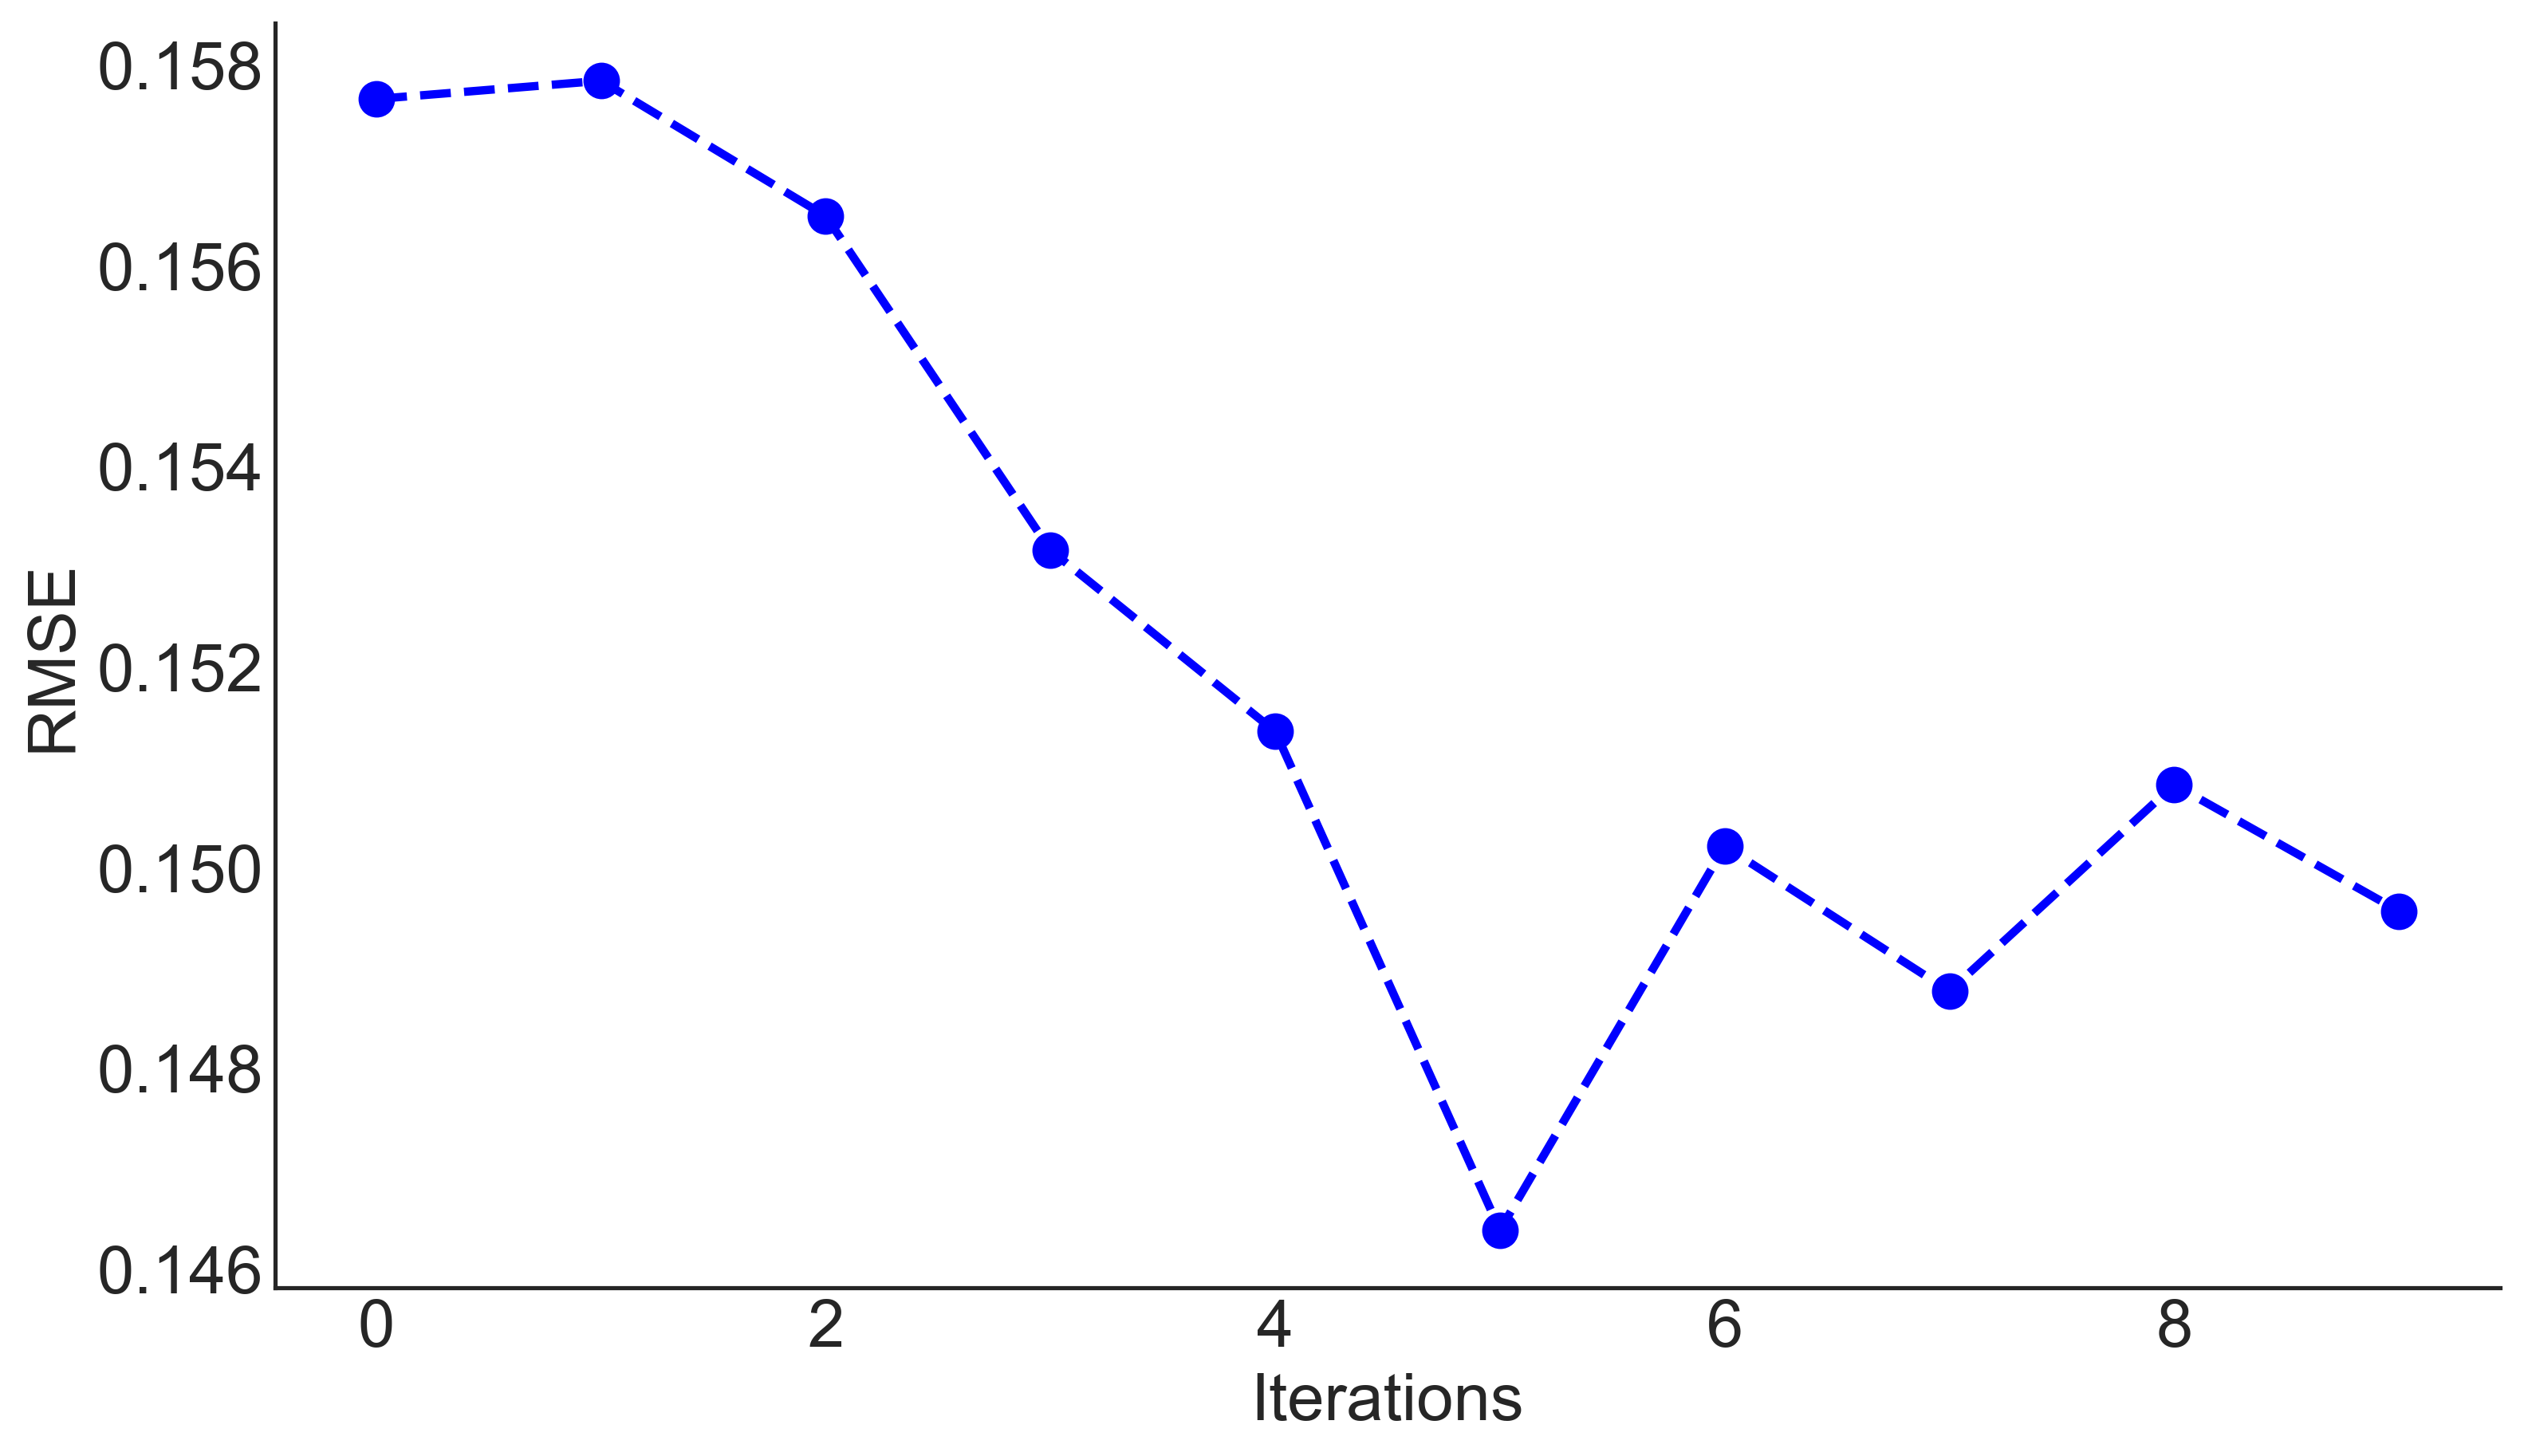

<Figure size 432x288 with 0 Axes>

In [41]:
figure(figsize=(12, 7), dpi=300)
colors=['blue', 'orange', 'brown', 'purple', 'olive']
plt.plot(X_rmse, color='b', linewidth=2.5, linestyle='dashed',
        marker='o', markersize=10)

plt.xlabel('Iterations')
plt.ylabel('RMSE')

plt.show()
# plt.savefig(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\RMSE_X.pdf',
#            bbox_inches='tight')
plt.clf()


**Accuracy change over iterations for Binary & Categorical sensors**

**Input:**   Accuracy score over iterations for Binary & Categorical sensors  
**Output:** Accuracy change plot (Binary & Categorical)

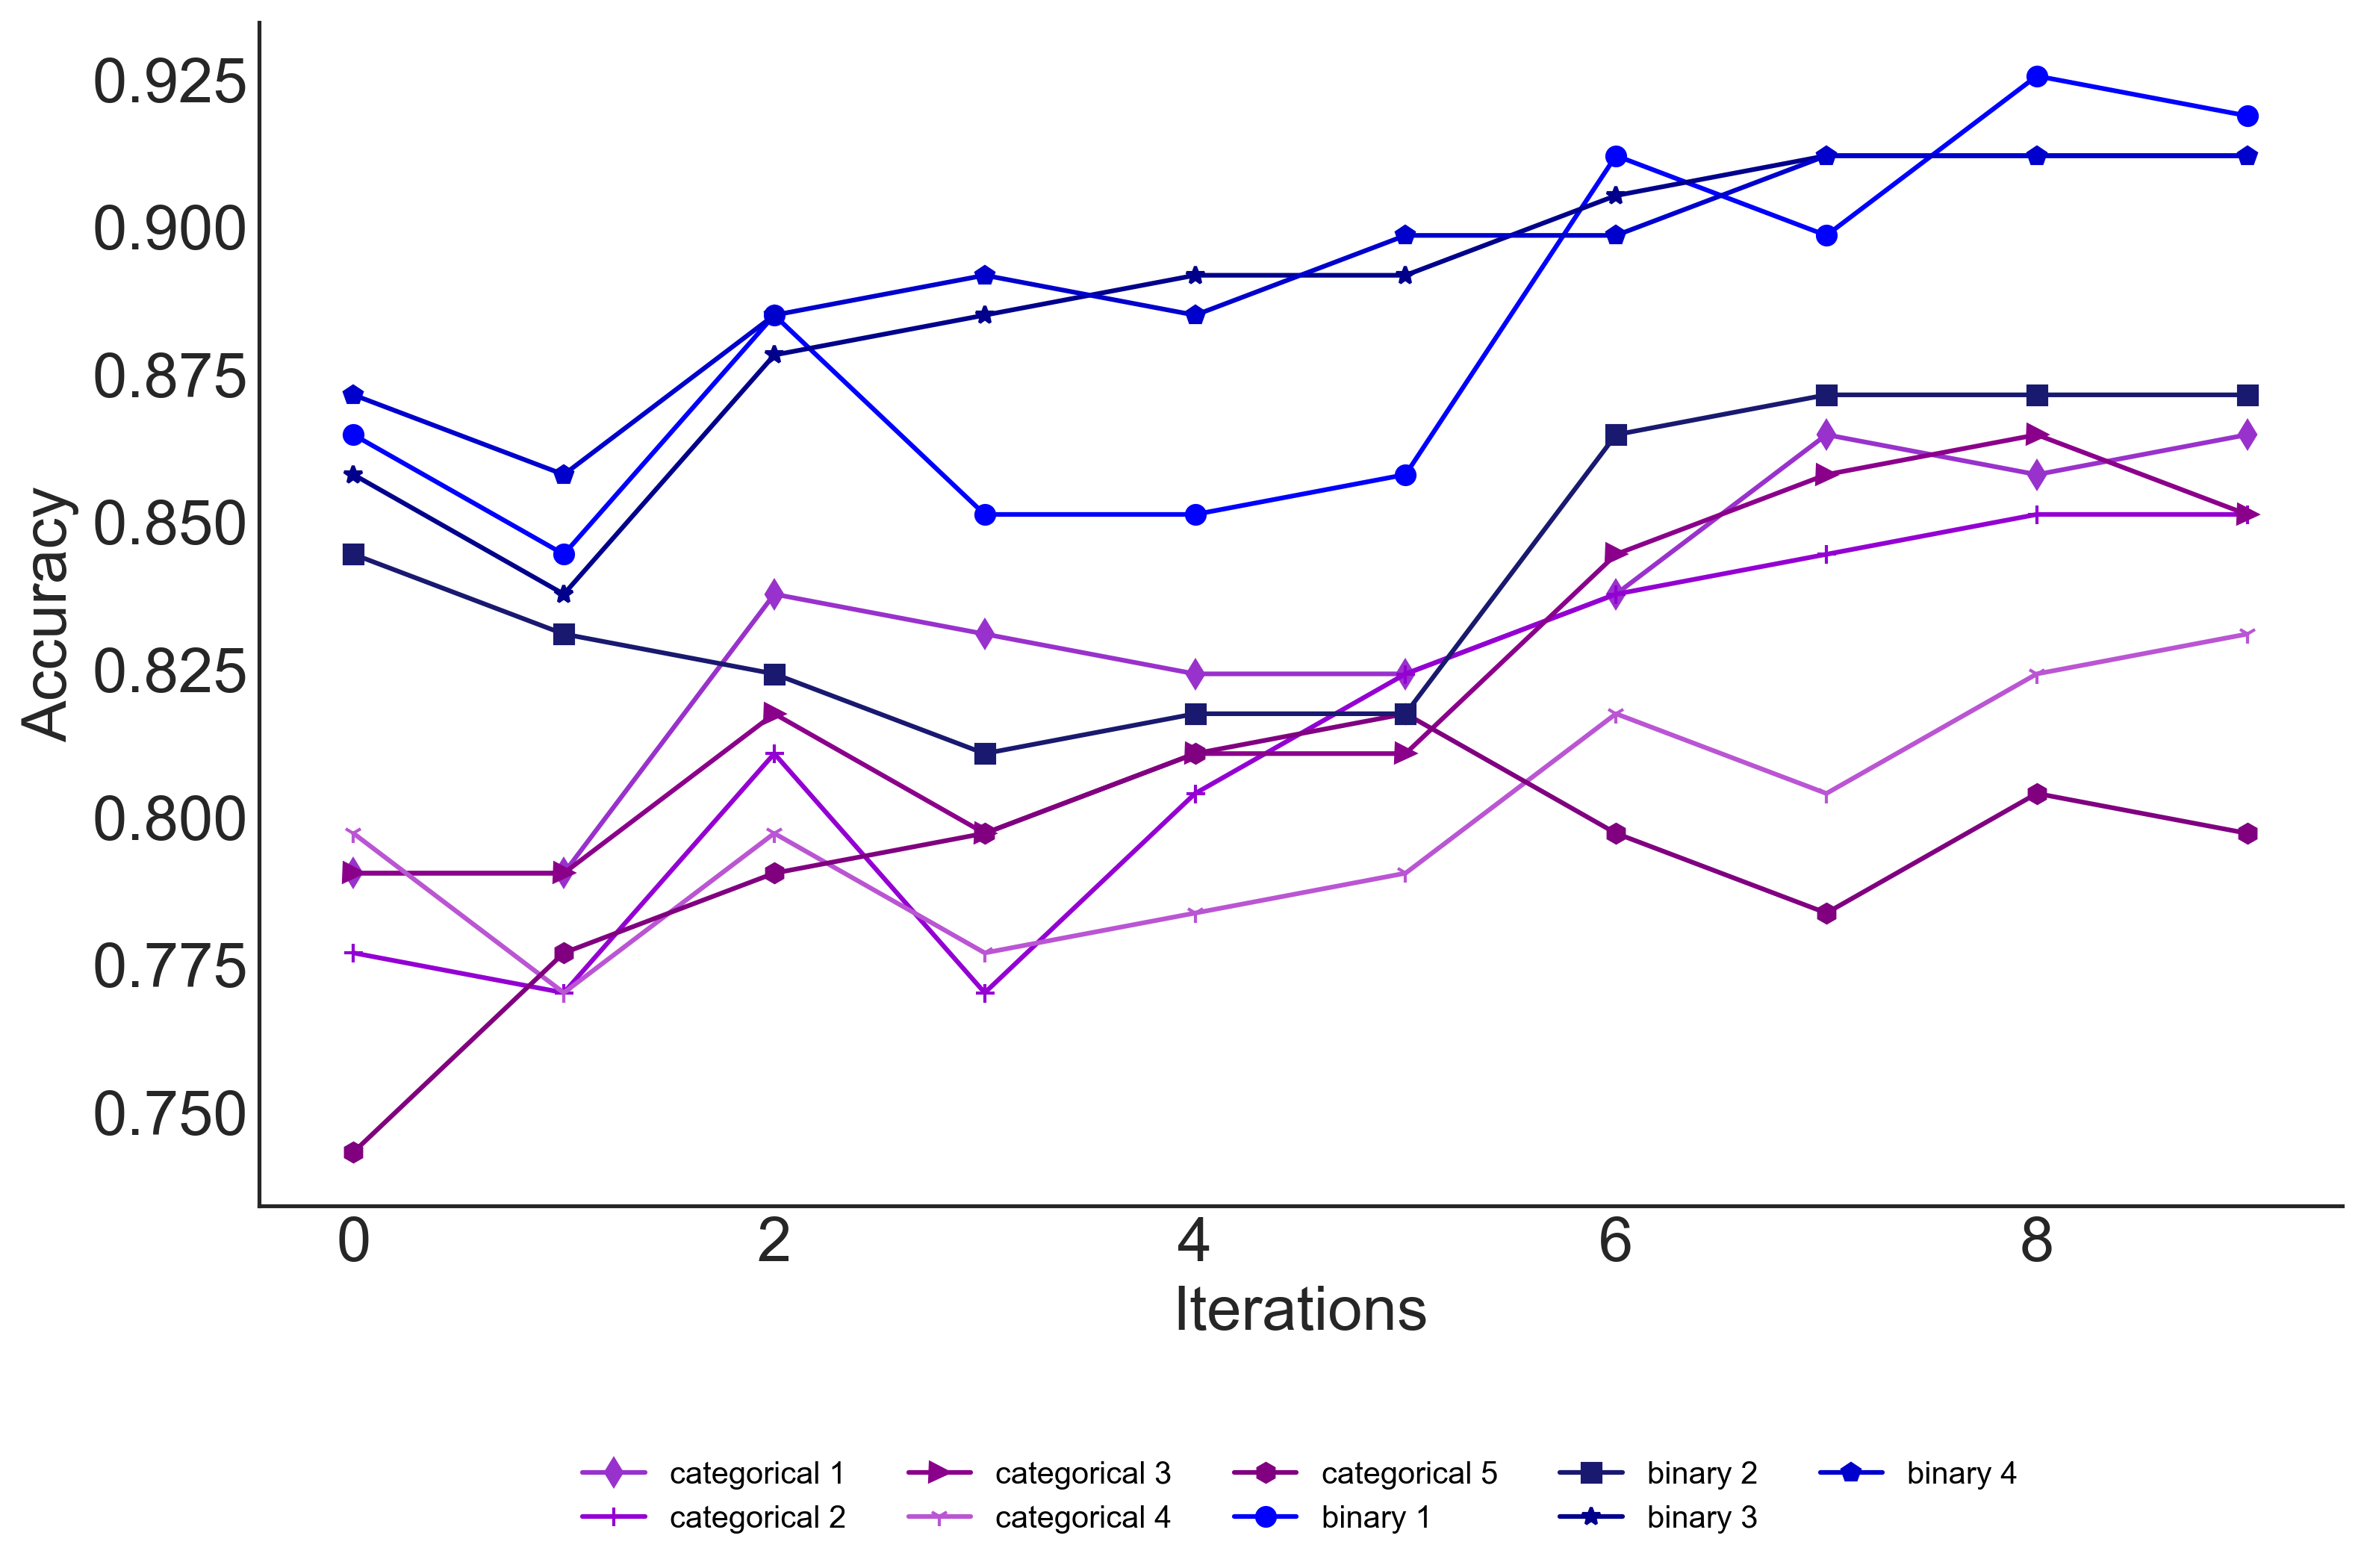

<Figure size 432x288 with 0 Axes>

In [42]:
figure(figsize=(12, 7), dpi=300)
markers_b=['o', 's', '*', 'p']
markers_c=['d', '+', '>', '1', 'h']
colors_bin=['blue', 'midnightblue', 'darkblue', 'mediumblue']
colors_cat=['darkorchid', 'darkviolet', 'darkmagenta', 'mediumorchid', 'purple']
fig=plt.figure(1)
for j in range(Cat_feature):
    plt.plot(np.array(cat_acc)[:,j], color=colors_cat[j], linewidth=1.5, marker=markers_c[j],
             label='categorical '+str(j+1))
for i in range(Bin_feature):
    plt.plot(np.array(bin_acc)[:,i], color=colors_bin[i], linewidth=1.5, marker= markers_b[i],
             label='binary '+str(i+1))


# plt.title('Accuracy for binary and categorical sensors')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.3), ncol=5)

plt.show()
# plt.savefig(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\Accuracy_bin_cat.pdf', bbox_inches='tight')
plt.clf()


### 8.4. Hidden states performance

**Estimates for continuous degradation state**

**Input:**  
* best 6 time series indices list
* True & estimated hazard rate

**Output:** 
* Confusion matrix
* True vs estimated degradation state plot

In [105]:
confusion_matrix(hidden_df_test.M_true, hidden_df_test.M_est)

array([[444,  72],
       [ 67, 830]], dtype=int64)

In [ ]:
for n in range(N,N+N):
    plt.plot([i for i in range(len(hidden_df_test[hidden_df_test.N==n]))], 
             hidden_df_test[hidden_df_test.N==n]['M_true'], color='g')
    plt.plot([i for i in range(len(hidden_df_test[hidden_df_test.N==n]))], 
             hidden_df_test[hidden_df_test.N==n]['M_est'])
    plt.show()
    plt.clf()

In [ ]:
for n in range(N,N+N):
    plt.plot([i for i in range(len(hidden_df_test[hidden_df_test.N==n]))], 
             hidden_df_test[hidden_df_test.N==n]['X_true'], color='g')
    plt.plot([i for i in range(len(hidden_df_test[hidden_df_test.N==n]))], 
             hidden_df_test[hidden_df_test.N==n]['X_est'])
    plt.show()
    plt.clf()

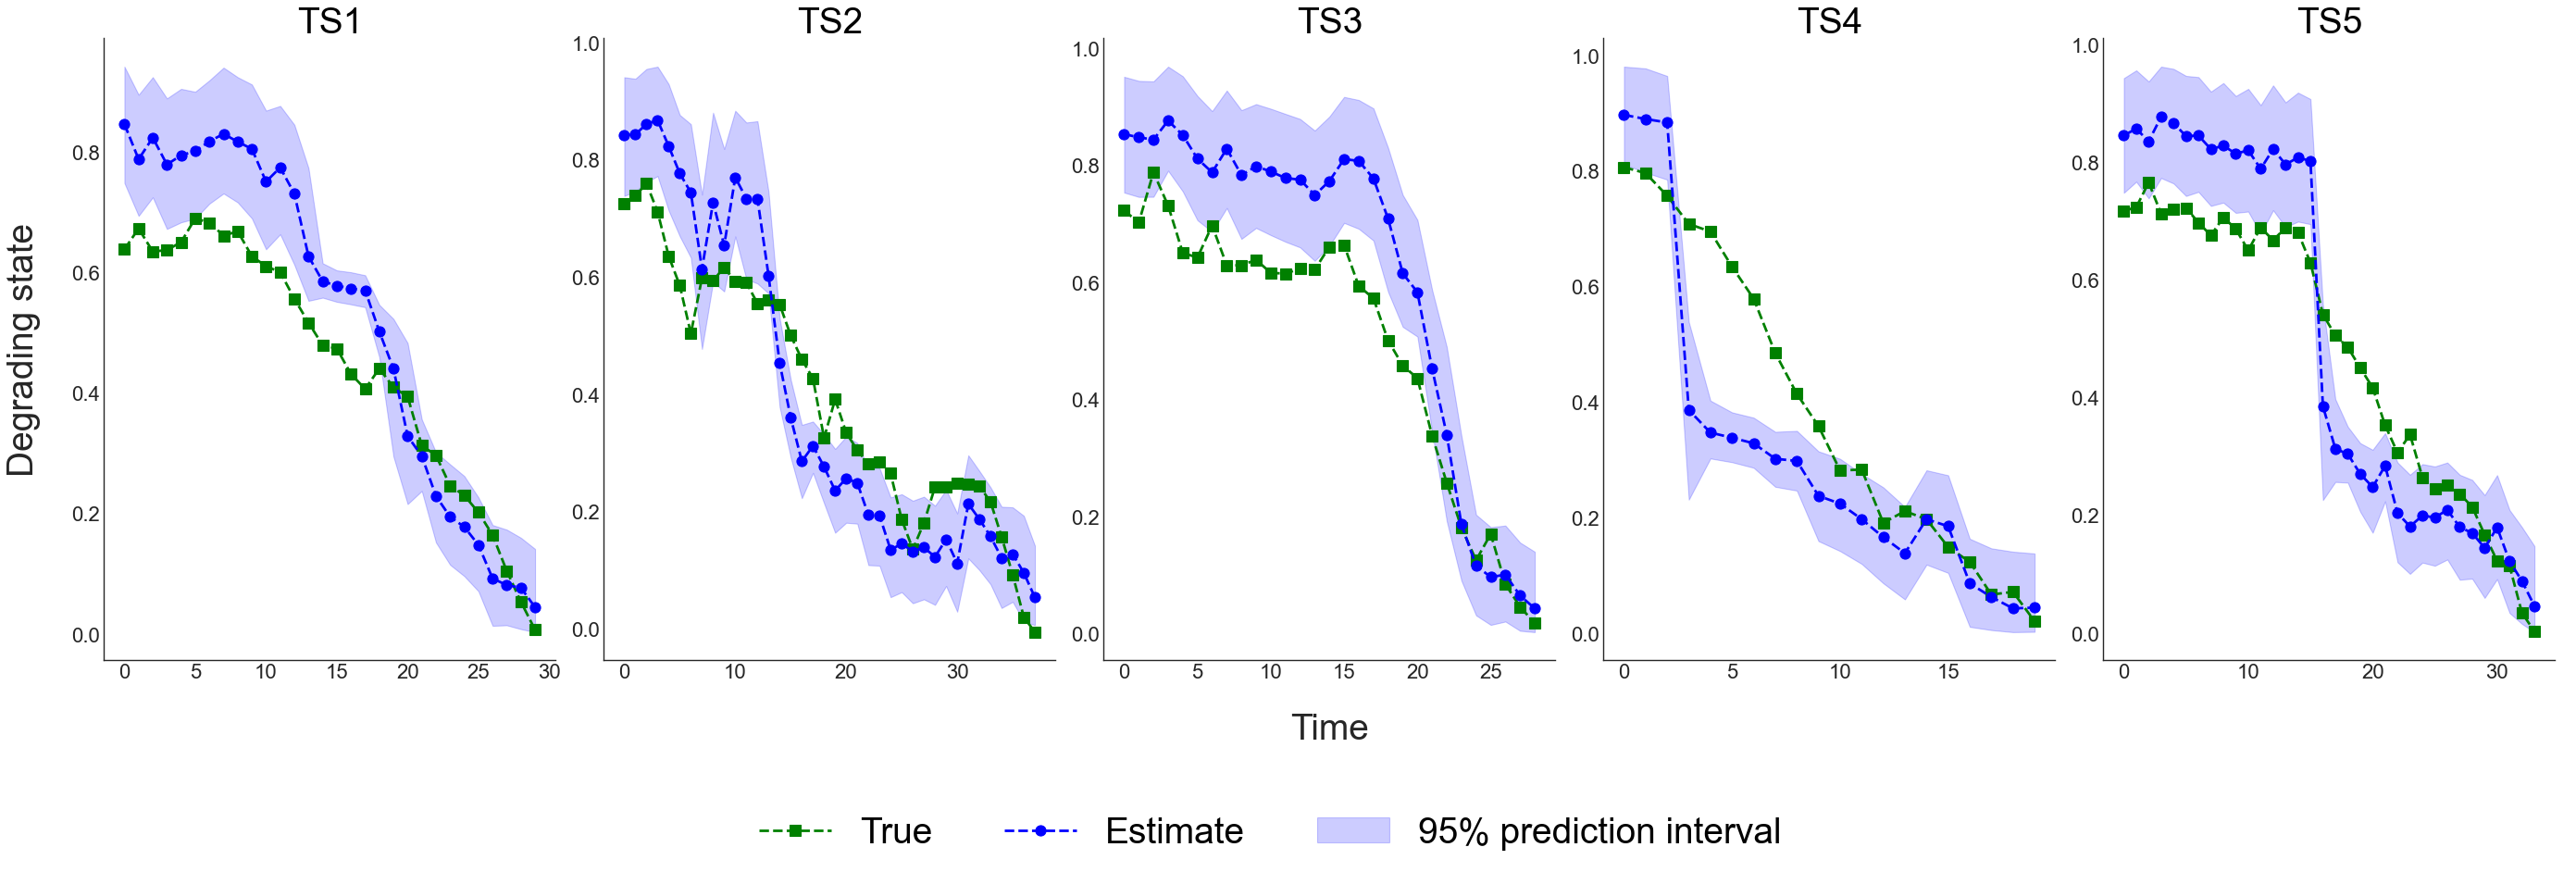

<Figure size 432x288 with 0 Axes>

In [114]:
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy

n_list_X=[51,61,71,81,91]
cols = ['TS1', 'TS2', 'TS3', 'TS4', 'TS5', 'TS6']
# rows = ['TS1', 'TS2', 'TS3', 'TS4', 'TS5', 'TS6']

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(35, 12), dpi=80)
# plt.setp(axes.flat, xlabel='X-label', ylabel='Y-label')
for n in range(5):
    axes[n].plot(hidden_df_test[hidden_df_test.N==n_list_X[n]]['X_true'].tolist(), 
                 color='g', label='True', linewidth=2.5, linestyle='dashed', 
                 marker='s', markersize=10)
    axes[n].plot(hidden_df_test[hidden_df_test.N==n_list_X[n]]['X_est'].tolist(), 
                 color='b', label='Estimate', linewidth=2.5, linestyle='dashed', 
                 marker='o', markersize=10)
    under_line     = hidden_df_test[hidden_df_test.N==n_list_X[n]]['X_sigma_est_l'].tolist()
    over_line      = hidden_df_test[hidden_df_test.N==n_list_X[n]]['X_sigma_est_h'].tolist()
    axes[n].fill_between([t for t in range(len(under_line))], under_line, 
                 over_line, color='b', alpha=.2, label='95% prediction interval') #std curves.
    axes[n].spines['top'].set_visible(False)
    axes[n].spines['right'].set_visible(False)
    axes[n].tick_params(labelsize=20)
pad = 5 # in points

for ax, col in zip(axes, cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad), fontsize=55,
                xycoords='axes fraction', textcoords='offset points',
                size=35, ha='center', va='baseline')

# for ax, row in zip(axes[:,0], rows):
#     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center')

fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.05, top=0.95, bottom=0.25)
ax=fig.add_subplot(111, frame_on=False)
# ax.spines['top'].set_color('none')
# ax.spines['bottom'].set_color('none')
# ax.spines['left'].set_color('none')
# ax.spines['right'].set_color('none')
ax.grid(False)
plt.tick_params(labelcolor='none', bottom=False, left=False)
ax.set_xlabel('Time', fontsize=35, labelpad=30)
ax.set_ylabel('Degrading state', fontsize=35, labelpad=30)
ax.facecolor='white'
handles,labels=axes[n].get_legend_handles_labels()
fig.legend(handles,labels,loc='lower center', bbox_to_anchor=(.5,0), ncol=3, fontsize=35, fancybox=True)
plt.show()
# fig.savefig(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\select_X.pdf')
plt.clf()

**Estimates for Lambda or hazard rate**

**Input:**   
* list of  6 time series indices list
* True & estimated hazard rate

**Output:** True vs estimated hazard rate plot

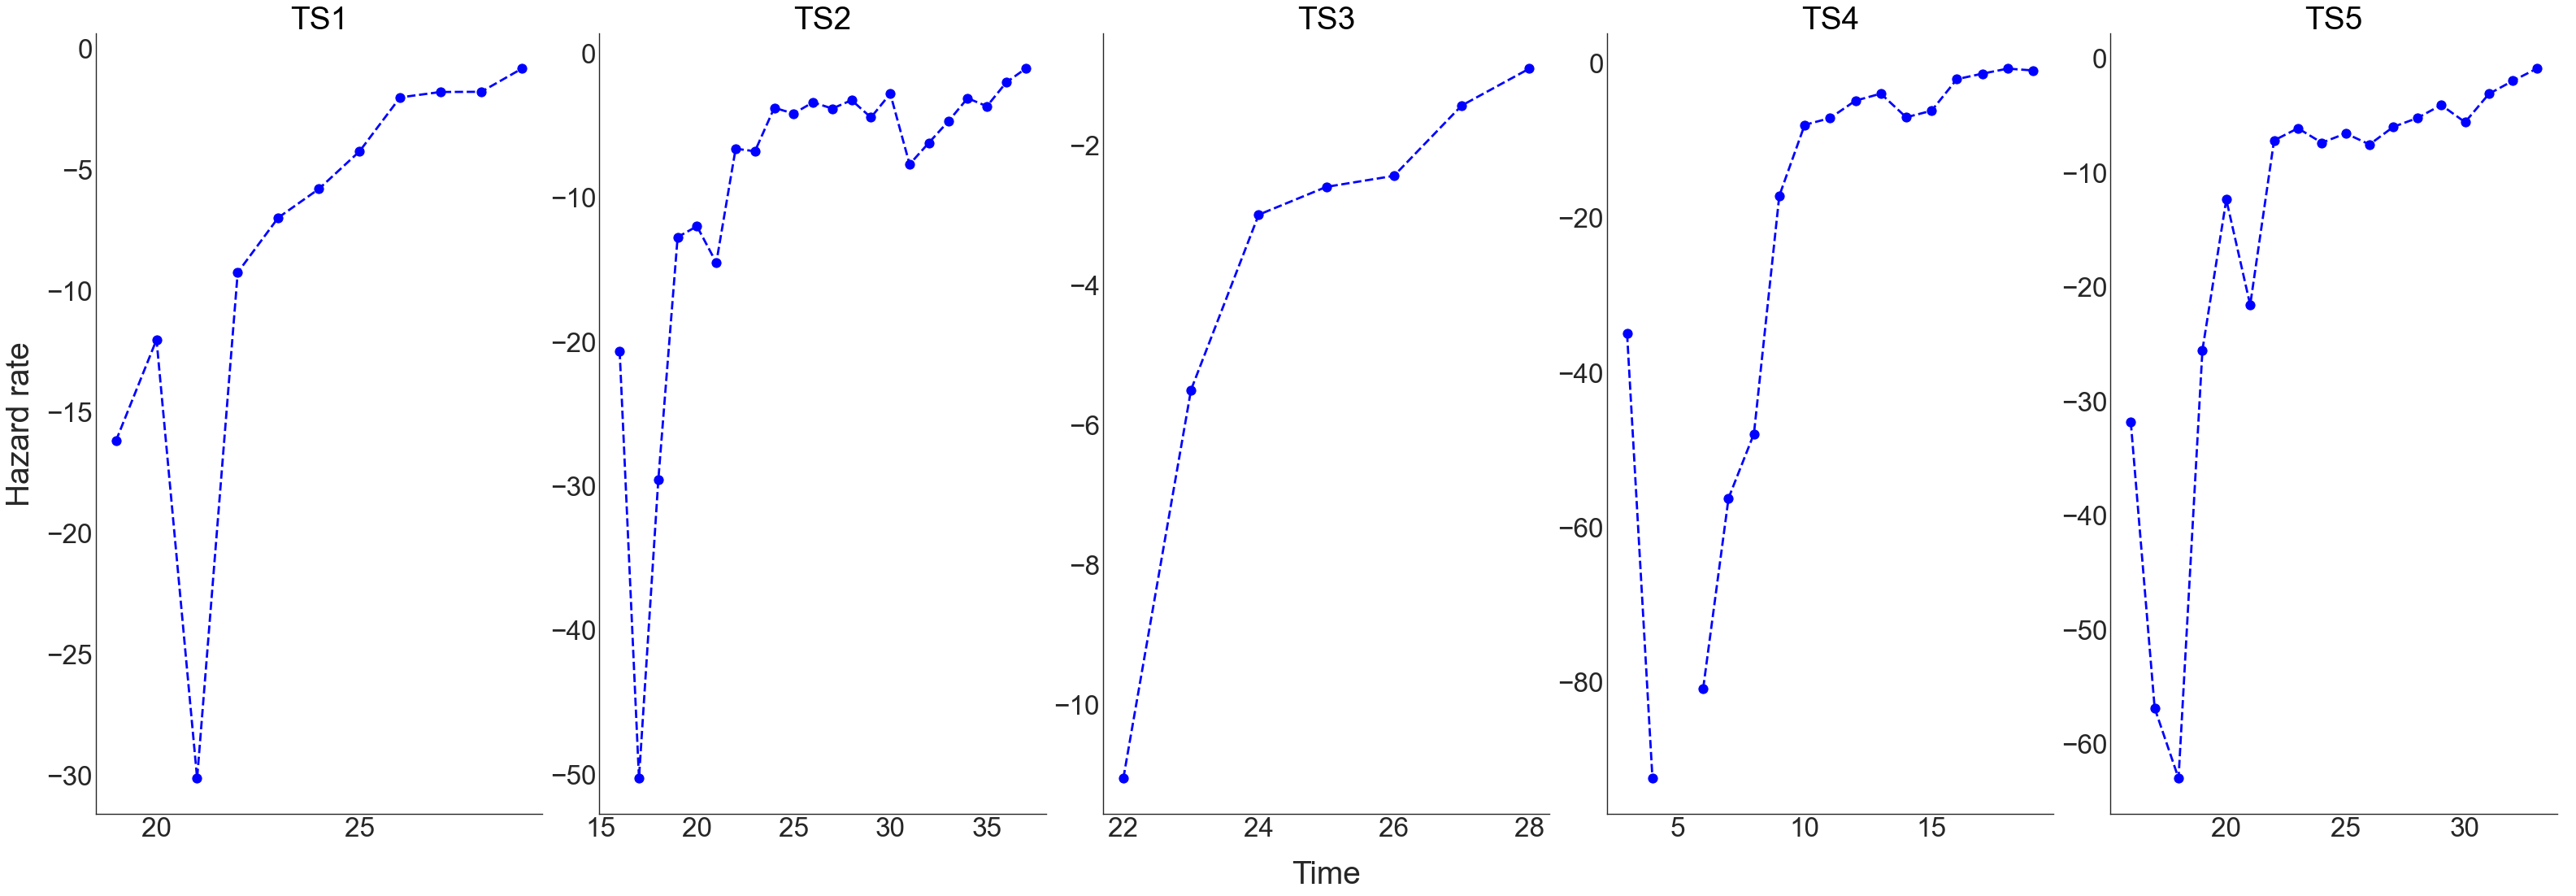

<Figure size 432x288 with 0 Axes>

In [113]:
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy

n_list_O=[51,61,71,81,91]
cols = ['TS1', 'TS2', 'TS3', 'TS4', 'TS5', 'TS6']
# rows = ['TS1', 'TS2', 'TS3', 'TS4', 'TS5', 'TS6']

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(40, 15), dpi=80)
# plt.setp(axes.flat, xlabel='X-label', ylabel='Y-label')
for n in range(5):
#     axes[n].plot(np.log(hidden_df_test[hidden_df_test.N==n_list_O[n]]['Lambda_true'].tolist()), color='g', label='True',
#                  linewidth=2.5, linestyle= 'dashed', marker='o', markersize=10)
    axes[n].plot([int(i) for i in range(len(hidden_df_test[hidden_df_test.N==n_list_O[n]]))],
                 np.log(hidden_df_test[hidden_df_test.N==n_list_O[n]]['Lambda_est'].tolist()), 
                 color='b', label='Estimate',
                 linewidth=2.5, linestyle= 'dashed', marker='o', markersize=10)
    axes[n].spines['top'].set_visible(False)
    axes[n].spines['right'].set_visible(False)
    axes[n].xaxis.get_major_locator().set_params(integer=True)
    axes[n].tick_params(labelsize=30)

pad = 5 # in points

for ax, col in zip(axes, cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad), fontsize=20,
                xycoords='axes fraction', textcoords='offset points',
                size=35, ha='center', va='baseline')

# for ax, row in zip(axes[:,0], rows):
#     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center')

fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.05, top=0.95, bottom=0.15)
ax=fig.add_subplot(111, frame_on=False)
# ax.spines['top'].set_color('none')
# ax.spines['bottom'].set_color('none')
# ax.spines['left'].set_color('none')
# ax.spines['right'].set_color('none')
ax.grid(False)
plt.tick_params(labelcolor='none', bottom=False, left=False)
ax.set_xlabel('Time', fontsize=35, labelpad=30)
ax.set_ylabel('Hazard rate', fontsize=35, labelpad=35)
handles,labels=axes[n].get_legend_handles_labels()
# fig.legend(handles,labels,loc='lower center', bbox_to_anchor=(.5,0), ncol=3, fontsize=35, fancybox=True)

plt.show()
# fig.savefig(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\select_O_without_true.pdf')
plt.clf()

**Estimates for discrete health mode**

**Input:**   
* list of  6 time series indices list
* True & estimated discrete health mode

**Output:** True vs estimated discrete health mode plot

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy

n_list_M=[51,61,71,81,91]
cols = ['TS1', 'TS2', 'TS3', 'TS4', 'TS5', 'TS6']
# rows = ['TS1', 'TS2', 'TS3', 'TS4', 'TS5', 'TS6']

fig, axes = plt.subplots(nrows=1, ncols=len(n_list_M), figsize=(35, 10), dpi=80)
# plt.setp(axes.flat, xlabel='X-label', ylabel='Y-label')

for n in range(len(n_list_M)):
  axes[n].plot([int(t) for t in range(len(hidden_df_test[hidden_df_test.N==n_list_M[n]]))],
               hidden_df_test[hidden_df_test.N==n_list_M[n]]['M_true'].astype(int).astype(str), 
               color='g', linewidth=3, linestyle='dashed', 
               marker='s', markersize=10, label='True')
  axes[n].plot([int(t) for t in range(len(hidden_df_test[hidden_df_test.N==n_list_M[n]]))],
               hidden_df_test[hidden_df_test.N==n_list_M[n]]['M_est'].astype(int).astype(str), 
               color='b', linewidth=3, linestyle='dashed', 
               marker='o', markersize=10, label='Estimate')
  axes[n].spines['top'].set_visible(False)
  axes[n].spines['right'].set_visible(False)
  axes[n].tick_params(labelsize=30)

pad = 5 # in points

for ax, col in zip(axes, cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=35, ha='center', va='baseline')

# for ax, row in zip(axes[:,0], rows):
#     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center')

fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.05, top=0.95, bottom=0.2)
ax=fig.add_subplot(111, frame_on=False)
# ax.spines['top'].set_color('none')
# ax.spines['bottom'].set_color('none')
# ax.spines['left'].set_color('none')
# ax.spines['right'].set_color('none')
ax.grid(False)
plt.tick_params(labelcolor='none', bottom=False, left=False)
ax.set_xlabel('Time', fontsize=35, labelpad=15)
ax.set_ylabel('Discrete health mode', fontsize=35, labelpad=30)
handles,labels=axes[n].get_legend_handles_labels()
fig.legend(handles,labels, loc='lower center', bbox_to_anchor=(0.5,0), ncol=2, fontsize=35, fancybox=True)
plt.show()
# fig.savefig(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\select_M.pdf')
plt.clf()



**Change of degrading state over percentage of lifetime**

**Input:** estimated degradation states with time  
**Output:** degradation state estimates vs percentage of lifetime plot

<Figure size 960x560 with 0 Axes>

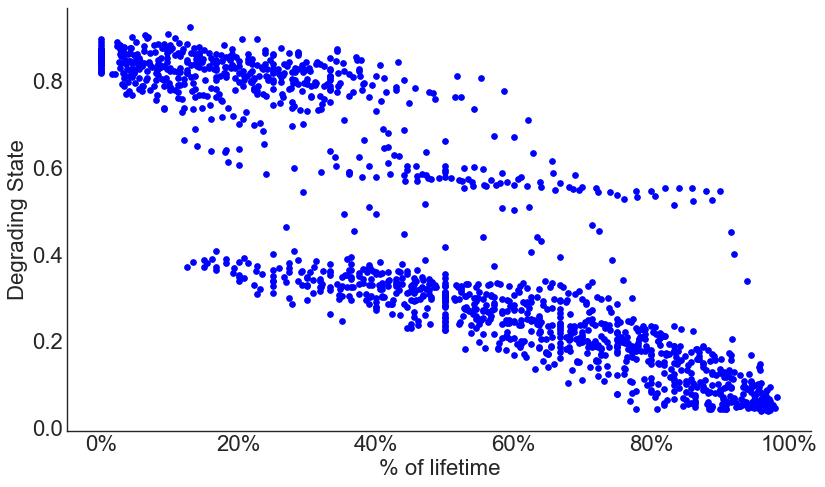

<Figure size 432x288 with 0 Axes>

In [111]:
import matplotlib.ticker as mtick
figure(figsize=(12, 7), dpi=80)

figure(figsize=(12, 7), dpi=80)
fig=plt.figure(1)
ax=fig.add_subplot(1,1,1)
# colors=['blue', 'orange', 'brown', 'purple', 'green']
# markers=['o', 's', 'p', '*', 'd']
# select_cont=[3,4,6,7,8]
for n in range(N,N+N):
    plt.plot([i*100/len(hidden_df_test[hidden_df_test.N==n]) 
              for i in range(len(hidden_df_test[hidden_df_test.N==n]))], 
             hidden_df_test[hidden_df_test.N==n]['X_est'], 
             color='blue', marker='o',
             markersize=5, linestyle='')

fmt='%.0f%%'
xticks=mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)
plt.xlabel('% of lifetime')
plt.ylabel('Degrading State')
# plt.legend(loc=1, bbox_to_anchor=(1,1))
# plt.yticks(np.arange(0.05,0.2, step=0.05))

plt.show()
# plt.savefig(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\X_Degrading.pdf',
#            bbox_inches='tight')
plt.clf()


**Change of hazard rate over percentage of lifetime**

**Input:** estimated hazard rates with time  

**Output:** hazard rate estimates vs percentage of lifetime plot

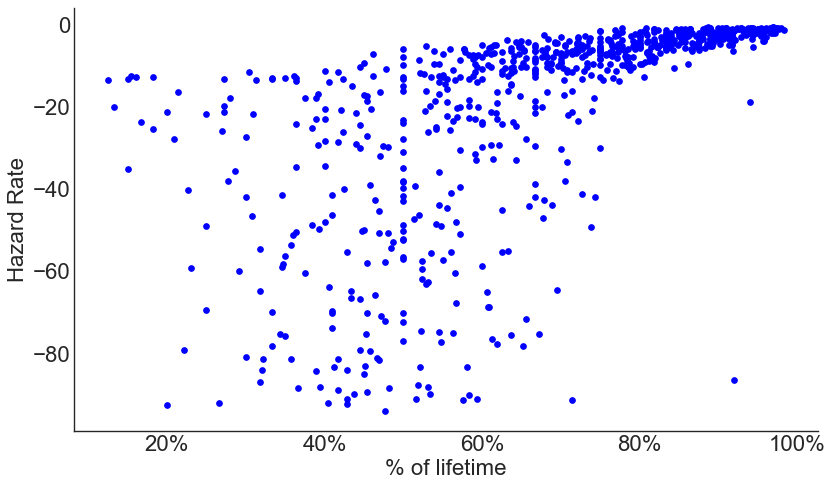

<Figure size 432x288 with 0 Axes>

In [115]:
import matplotlib.ticker as mtick

figure(figsize=(12, 7), dpi=80)
fig=plt.figure(1)
ax=fig.add_subplot(1,1,1)
# colors=['blue', 'orange', 'brown', 'purple', 'green']
# markers=['o', 's', 'p', '*', 'd']
# select_cont=[3,4,6,7,8]
for n in range(N,N+N):
    plt.plot([i*100/len(hidden_df_test[hidden_df_test.N==n]) 
              for i in range(len(hidden_df_test[hidden_df_test.N==n]))], 
             np.log(hidden_df_test[hidden_df_test.N==n]['Lambda_est']), 
             color='blue', marker='o',
             markersize=5, linestyle='')

fmt='%.0f%%'
xticks=mtick.FormatStrFormatter(fmt)
ax.xaxis.set_major_formatter(xticks)
plt.xlabel('% of lifetime')
plt.ylabel('Hazard Rate')
# plt.legend(loc=1, bbox_to_anchor=(1,1))
# plt.yticks(np.arange(0.05,0.2, step=0.05))

plt.show()
# plt.savefig(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\Lambda_all.pdf',
#            bbox_inches='tight')
plt.clf()


### 8.5. Sensor Prediction Performance

6 selected time series showing the estimates for continuous sensors

**Input:**   
* list of  6 time series indices list
* True & estimated sensor values
* Prediction interval for sensor prediction

**Output:** True vs Estimates plot with prediction interval for continuous sensors

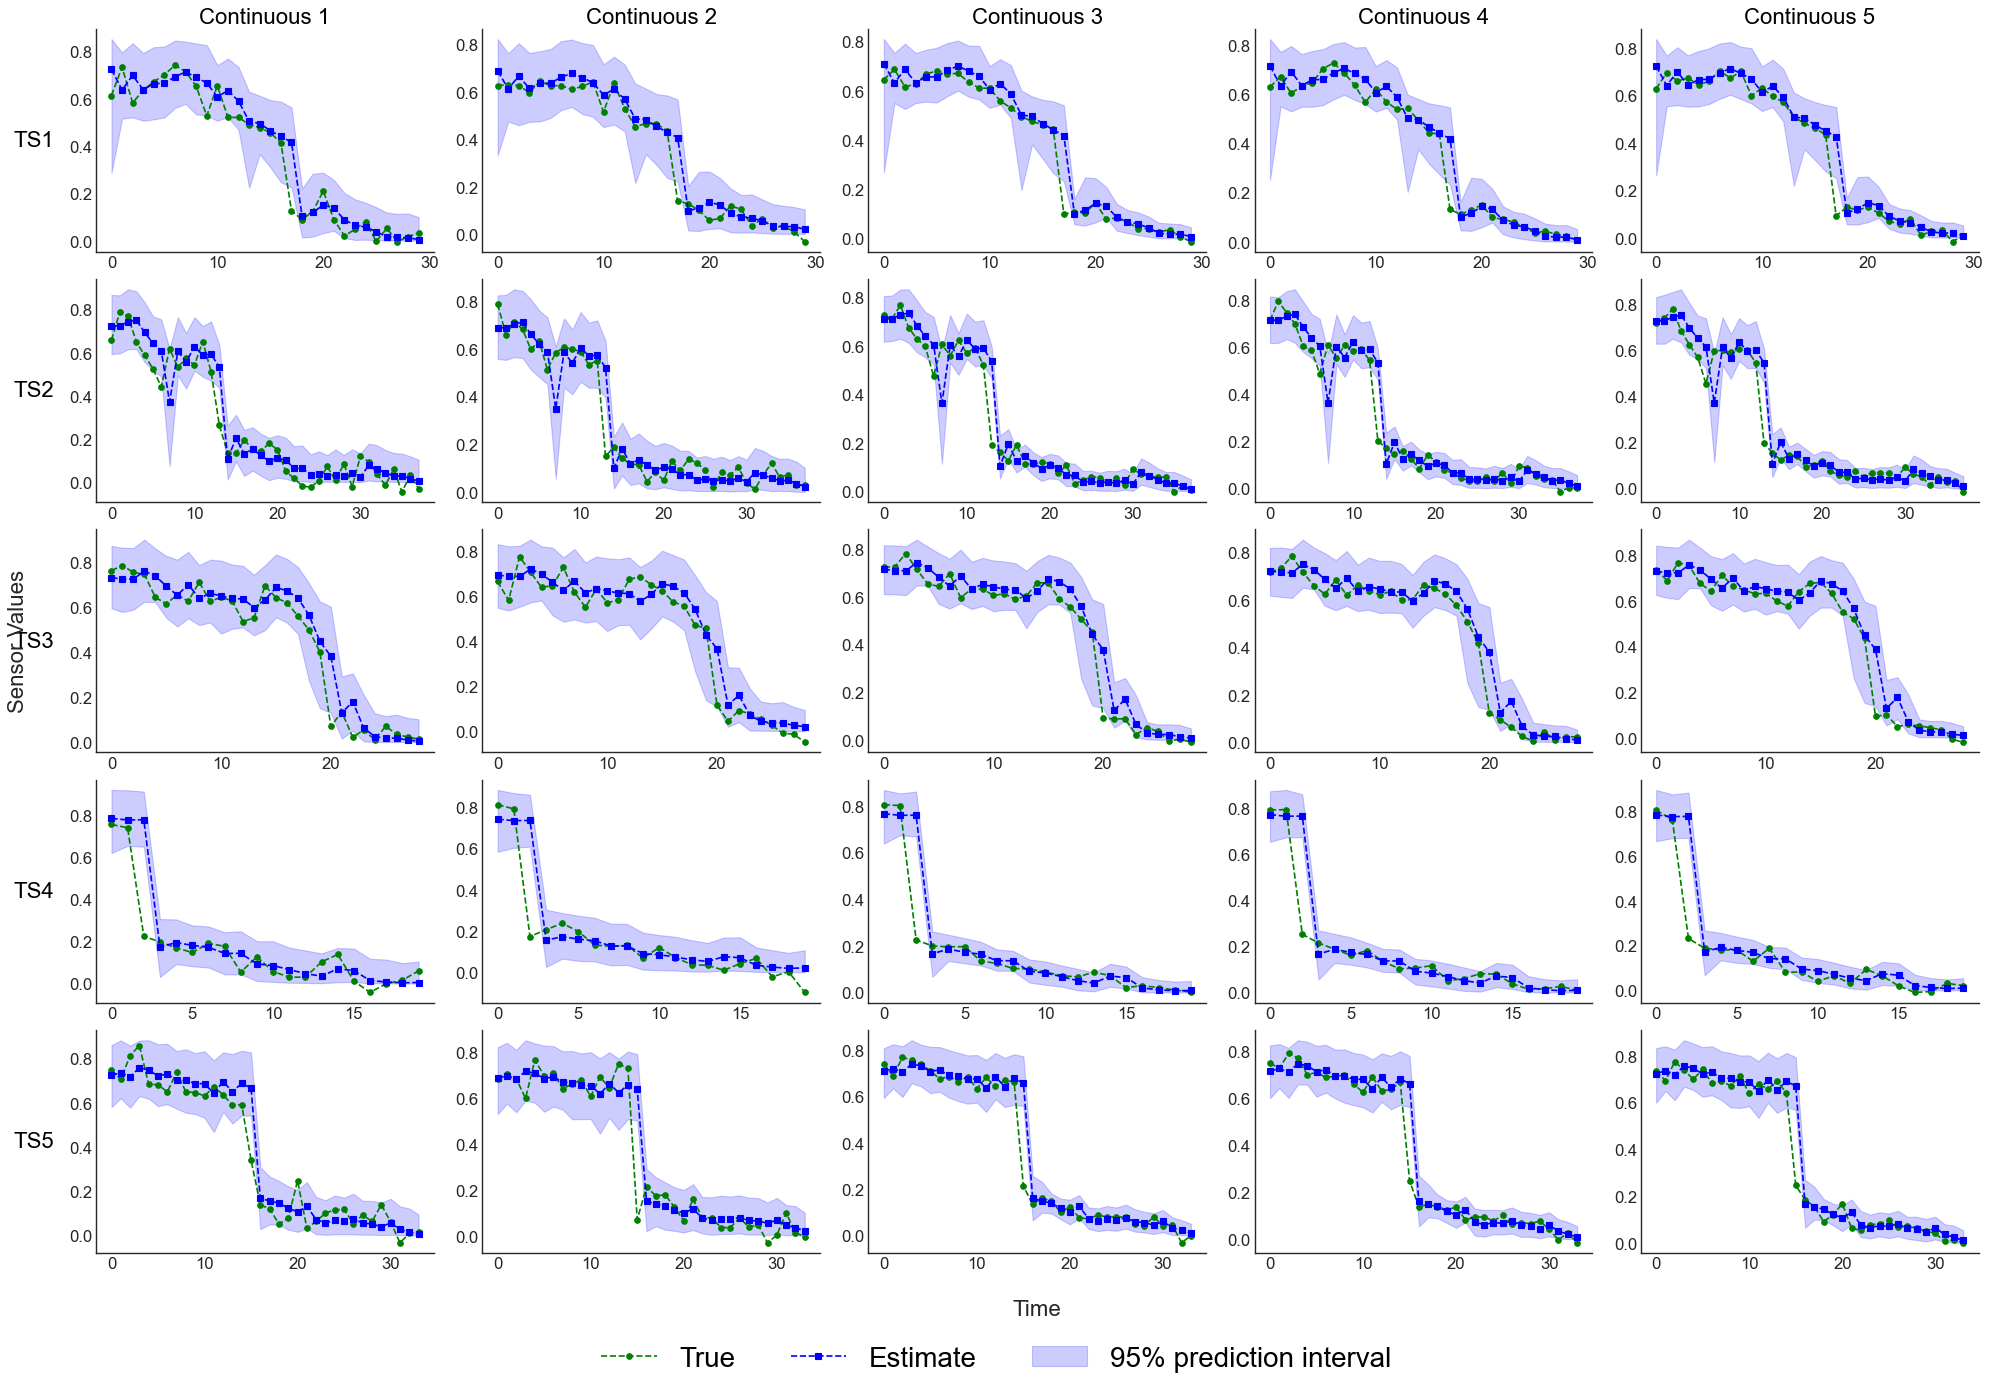

<Figure size 432x288 with 0 Axes>

In [116]:
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy

n_list=[51,61,71,81,91]
cols = ['Continuous 1','Continuous 2','Continuous 3','Continuous 4','Continuous 5']
rows = ['TS1', 'TS2', 'TS3', 'TS4', 'TS5', 'TS6']

fig, axes = plt.subplots(nrows=len(n_list), ncols=Cont_feature, figsize=(25, 18), dpi=80)
# plt.setp(axes.flat, xlabel='X-label', ylabel='Y-label')
for n in range(len(n_list)):
    for i in range(Cont_feature):
        axes[n,i].plot([t for t in range(len(cont_sensor_df_list[i][cont_sensor_df_list[i]['N']==n_list[n]]))],
                       cont_sensor_df_list[i][cont_sensor_df_list[i]['N']==n_list[n]]['True'], 
                       color='g', linewidth=1.5, linestyle='dashed', 
                       marker='o', markersize=5, label='True')
        axes[n,i].plot([t for t in range(len(cont_sensor_df_list[i][cont_sensor_df_list[i]['N']==n_list[n]]))],
                       cont_sensor_df_list[i][cont_sensor_df_list[i]['N']==n_list[n]]['Est'], color='b', linewidth=1.5,
                       linestyle='dashed', marker='s', markersize=5, label='Estimate')

        under_line     = cont_sensor_df_list[i][cont_sensor_df_list[i]['N']==n_list[n]]['sigma_est_l']
        over_line      = cont_sensor_df_list[i][cont_sensor_df_list[i]['N']==n_list[n]]['sigma_est_h']
        axes[n,i].fill_between([t for t in range(len(cont_sensor_df_list[i][cont_sensor_df_list[i]['N']==n_list[n]]))], 
                               under_line, over_line, color='b', alpha=.2, label='95% prediction interval') #std curves.
        axes[n,i].tick_params(labelsize=15)
pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size=20, ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=20, ha='right', va='center')

fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.05, top=0.95, bottom=0.1)
ax=fig.add_subplot(111, frame_on=False)
# ax.spines['top'].set_color('none')
# ax.spines['bottom'].set_color('none')
# ax.spines['left'].set_color('none')
# ax.spines['right'].set_color('none')
ax.grid(False)
plt.tick_params(labelcolor='none', bottom=False, left=False)
ax.set_xlabel('Time', fontsize=20, labelpad=20)
ax.set_ylabel('Sensor Values', fontsize=20, labelpad=30)
handles,labels=axes[n,i].get_legend_handles_labels()
fig.legend(handles,labels, loc='lower center', bbox_to_anchor=(0.5,0), ncol=3, fontsize=25, fancybox=True)
plt.show()
# fig.savefig(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\select_Y.pdf', bbox_inches='tight')
plt.clf()

**Boxplot Binary sensor probabilities**

**Input:**   
* list of  6 time series indices list
* list of true probabilities
* estimated probabilities for binary sensors

**Output:** Boxplot showing distribution of estimated probabilities against true probabilities for binary sensors

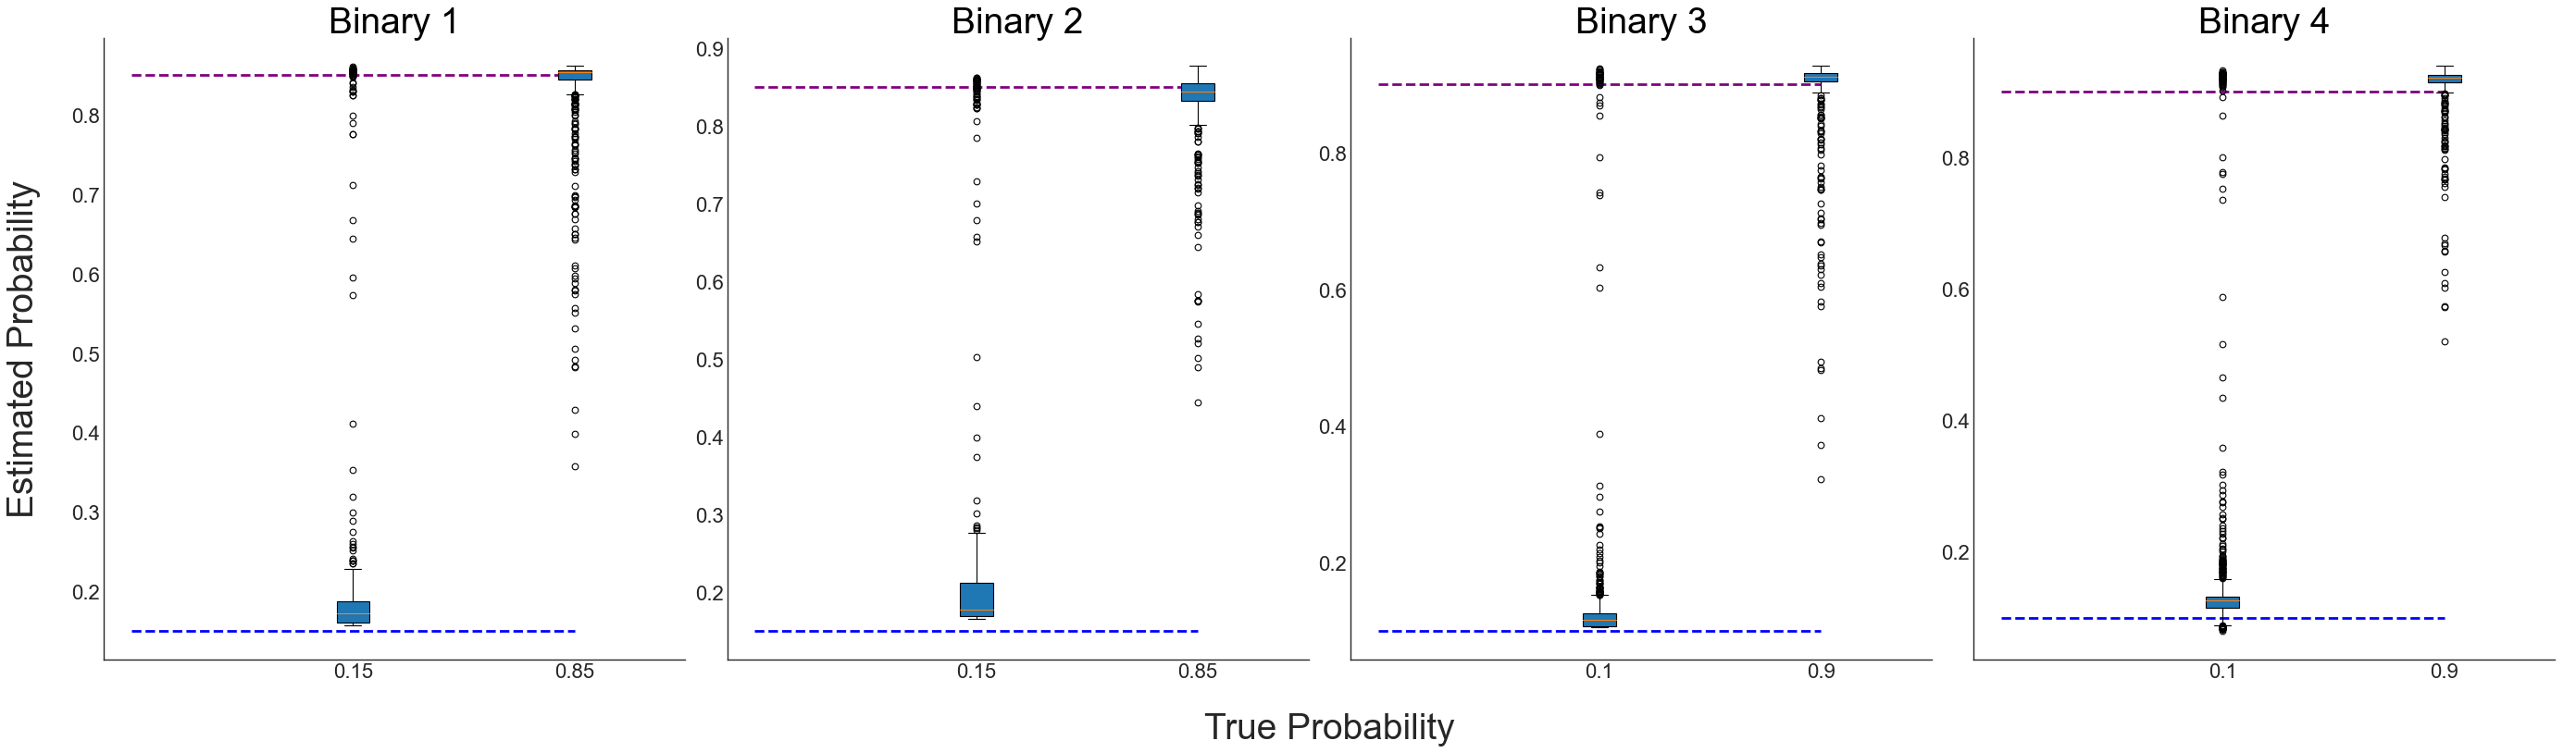

<Figure size 432x288 with 0 Axes>

In [117]:
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy

n_list_X=[51,61,71,81,91]
cols = ['Binary '+str(i+1) for i in range(Bin_feature)]
# rows = ['TS1', 'TS2', 'TS3', 'TS4', 'TS5', 'TS6']

fig, axes = plt.subplots(nrows=1, ncols=Bin_feature, figsize=(35, 12), dpi=80)
# plt.setp(axes.flat, xlabel='X-label', ylabel='Y-label')
for k in range(Bin_feature):
#     for n in range(50,100):
    axes[k].plot([0.85  if k<2 else 0.9 for i in range(3)],
                 linewidth=2.5, linestyle='dashed', color='purple')
    axes[k].plot([0.15  if k<2 else 0.1 for i in range(3)],
                 linewidth=2.5, linestyle='dashed', color='b')
    k_prob1=0.15 if k<2 else 0.1
    k_prob2=0.85 if k<2 else 0.9
    bp_data=[bin_sensor_df_list[k][bin_sensor_df_list[k]['True_Prob']==k_prob1]['Bin_Prob'],
             bin_sensor_df_list[k][bin_sensor_df_list[k]['True_Prob']==k_prob2]['Bin_Prob']]
    axes[k].boxplot(bp_data, labels=[str(k_prob1), str(k_prob2)],patch_artist=True)




    axes[k].spines['top'].set_visible(False)
    axes[k].spines['right'].set_visible(False)
    axes[k].tick_params(labelsize=20)
pad = 5 # in points

for ax, col in zip(axes, cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad), fontsize=55,
                xycoords='axes fraction', textcoords='offset points',
                size=35, ha='center', va='baseline')

# for ax, row in zip(axes[:,0], rows):
#     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center')

fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.05, top=0.95, bottom=0.25)
ax=fig.add_subplot(111, frame_on=False)
# ax.spines['top'].set_color('none')
# ax.spines['bottom'].set_color('none')
# ax.spines['left'].set_color('none')
# ax.spines['right'].set_color('none')
ax.grid(False)
plt.tick_params(labelcolor='none', bottom=False, left=False)
ax.set_xlabel('True Probability', fontsize=35, labelpad=30)
ax.set_ylabel('Estimated Probability', fontsize=35, labelpad=30)
ax.facecolor='white'

# handles,labels=axes[k].get_legend_handles_labels()
# fig.legend([handles[0],handles[1]],[labels[0],labels[1]],loc='lower center', bbox_to_anchor=(.5,0), ncol=3, fontsize=35, fancybox=True)
plt.show()
# fig.savefig(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\binary_box.pdf')
plt.clf()


**Boxplot for categorical sensor probabilities**

**Input:**  
* list of  6 time series indices list
* list of true probabilities
* estimated probabilities for categorical sensors


**Output:** Boxplot showing distribution of estimated probabilities against true probabilities for categorical sensors

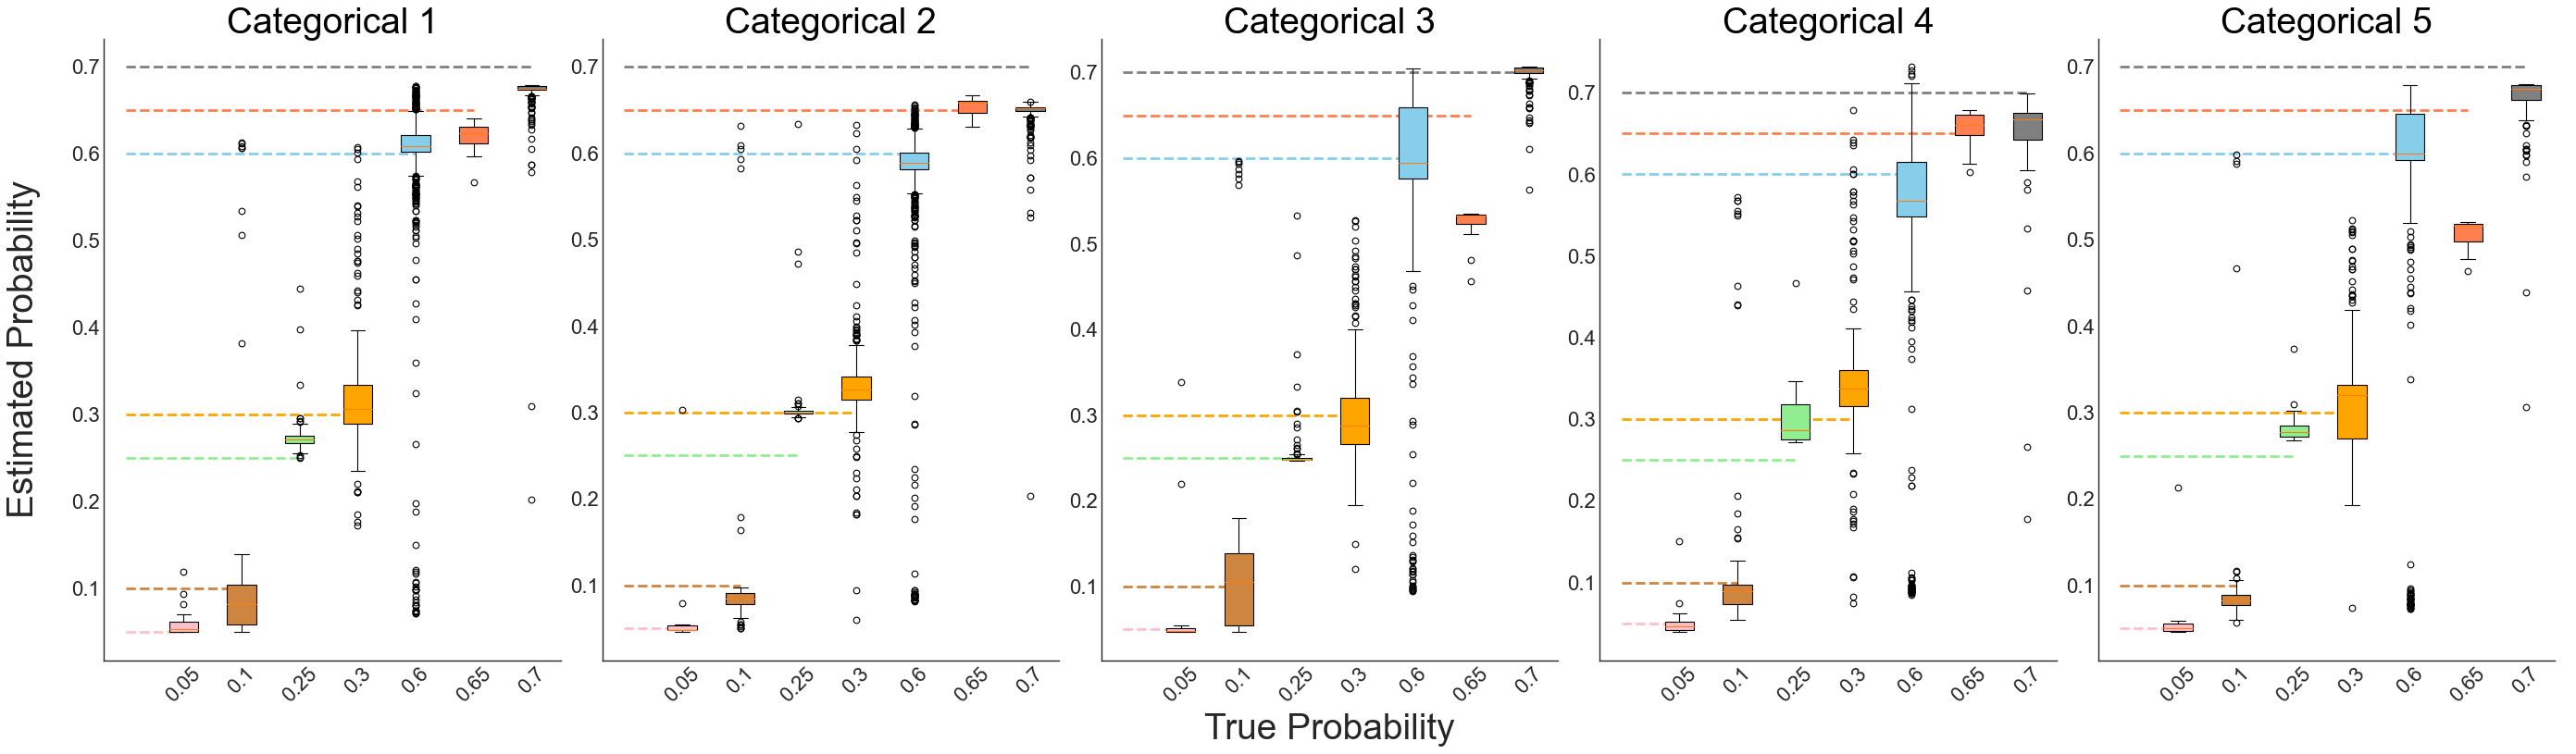

<Figure size 432x288 with 0 Axes>

In [118]:
import matplotlib.pyplot as plt
from matplotlib.transforms import offset_copy
# Pr_YCk_h=np.array([[[0.10,0.30,0.60] for i in range(Cat_feature)],
#                   [[0.60,0.30,0.10] for i in range(Cat_feature)]]) #x>=0.5

# Pr_YCk_l=np.array([[[0.05,0.65,0.30] for i in range(Cat_feature)],
#                   [[0.70,0.25,0.05] for i in range(Cat_feature)]]) #x<0.5

n_list_X=[51,61,71,81,91]
k_prob=[0.05, 0.10, 0.25, 0.30, 0.60, 0.65, 0.70]
cols = ['Categorical '+str(i+1) for i in range(Cat_feature)]
# rows = ['TS1', 'TS2', 'TS3', 'TS4', 'TS5', 'TS6']

fig, axes = plt.subplots(nrows=1, ncols=Cat_feature, figsize=(35, 12), dpi=80)
# plt.setp(axes.flat, xlabel='X-label', ylabel='Y-label')
for k in range(Cat_feature):
    

    colors = ['pink', 'peru', 'lightgreen', 'orange', 'skyblue', 'coral', 'gray']
    for c in range(len(colors)):
        axes[k].plot([k_prob[c] for i in range(c+2)],
                     linewidth=2.5, linestyle='dashed', color=colors[c])
#     axes[k].plot([0.15  if k<2 else 0.1 for i in range(3)],
#                  linewidth=2.5, linestyle='dashed', color='b')

    bp_data=[cat_sensor_df_list[k][cat_sensor_df_list[k]['True_prob']==k_prob[i]]['Est_prob']
             for i in range(len(k_prob))]
    bp_plot=axes[k].boxplot(bp_data, labels=[str(k_prob[i]) for i in range(len(k_prob))],
                    patch_artist=True)

    axes[k].spines['top'].set_visible(False)
    axes[k].spines['right'].set_visible(False)
    axes[k].tick_params(labelsize=20)
    axes[k].tick_params(axis='x', labelrotation = 45)

    # fill with colors
    for patch, color in zip(bp_plot['boxes'], colors):
            patch.set_facecolor(color)
    

#     axes[k].set_xticks(np.arange(0, 1, step=0.2))
#     axes[k].set_yticks(np.arange(0, 1, step=0.2))
pad = 5 # in points

for ax, col in zip(axes, cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad), fontsize=55,
                xycoords='axes fraction', textcoords='offset points',
                size=35, ha='center', va='baseline')

# for ax, row in zip(axes[:,0], rows):
#     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size='large', ha='right', va='center')

fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.05, top=0.95, bottom=0.25)
ax=fig.add_subplot(111, frame_on=False)
# ax.spines['top'].set_color('none')
# ax.spines['bottom'].set_color('none')
# ax.spines['left'].set_color('none')
# ax.spines['right'].set_color('none')
ax.grid(False)
plt.tick_params(labelcolor='none', bottom=False, left=False)
ax.set_xlabel('True Probability', fontsize=35, labelpad=30)
ax.set_ylabel('Estimated Probability', fontsize=35, labelpad=30)
ax.facecolor='white'
# handles,labels=axes[k].get_legend_handles_labels()
# fig.legend([handles[0],handles[1],handles[2]],
#            [labels[0],labels[1],labels[2]],
#            loc='lower center', bbox_to_anchor=(.5,0), 
#            ncol=3, fontsize=35, fancybox=True)
plt.show()
# fig.savefig(r'C:\Users\Administrator\OneDrive - University of Miami\PhD_task_5\Weekly Summary\EM_results_9Feb\categorical_box.pdf')
plt.clf()
